# **Twitter Sentiment Analysis**

This project focuses on classifying emotions in text using Deep learning models, specifically targeting sadness, joy, love, anger, fear, and surprise. The objective is to accurately predict the state of emotion behind textual inputs, aiding in the understanding and classification of human emotions expressed on Twitter. The project's goal is to create a reliable system that can identify emotions in text and provide insights for applications in social media monitoring, sentiment analysis, and customer feedback analysis.

Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import tensorflow as tf
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import numpy as np
import time
import datetime
import random
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,classification_report
import torch.nn.functional as cp

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

#device = torch.device("cpu")
print(device)

cuda


**Loading the data **

In [ ]:
train_file = '/content/drive/My Drive/DL project ALina/training.csv'
valdi_file = '/content/drive/My Drive/DL project ALina/validation.csv'
test_file = '/content/drive/My Drive/DL project ALina/test.csv'

In [ ]:
train = pd.read_csv(train_file)
valdi = pd.read_csv(valdi_file)
test = pd.read_csv(test_file)

df = pd.concat([train, valdi, test], ignore_index=True)


**Data Description**

In [ ]:
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
19995,i just keep feeling like someone is being unki...,3
19996,im feeling a little cranky negative after this...,3
19997,i feel that i am useful to my people and that ...,1
19998,im feeling more comfortable with derby i feel ...,1


In [ ]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
df['label'].unique()

array([0, 3, 2, 5, 4, 1])

In [ ]:
df.shape

(20000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
df.describe(include='all')

,text,label
count,20000,20000.000000
unique,19948,NaN
top,i will feel as though i am accepted by as well...,NaN
freq,2,NaN
mean,NaN,1.562850
std,NaN,1.496684
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,3.000000


**Checking Missing values**

In [ ]:
# Print missing values in train data
print("Missing values in train data:")
print(df.isnull().sum())

Missing values in train data:
text     0
label    0
dtype: int64


**Checking duplicated values**

In [ ]:
print("Duplicated values in train data:")
print(df.duplicated().sum())


Duplicated values in train data:
1


**handling duplicated values**

In [ ]:
df = df.drop_duplicates()

In [ ]:
print("Duplicated values in train data:")
print(df.duplicated().sum())

Duplicated values in train data:
0


In [ ]:
dict = { 0 : 'sadness' , 1 : 'joy' , 2 : 'love', 3 : 'anger' , 4 : 'fear' , 5 : 'superise'}

In [ ]:
train['label_name'] = train['label'].map(dict)
train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


**Data Visulization**

<Axes: ylabel='count'>

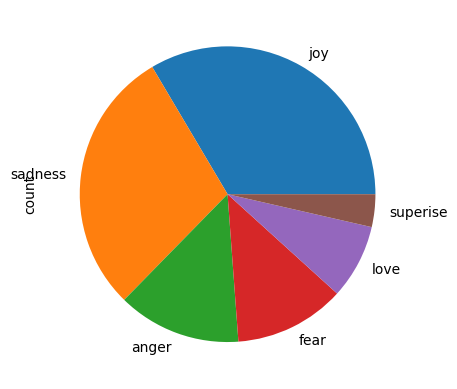

In [ ]:
train['label_name'].value_counts().plot(kind = 'pie')

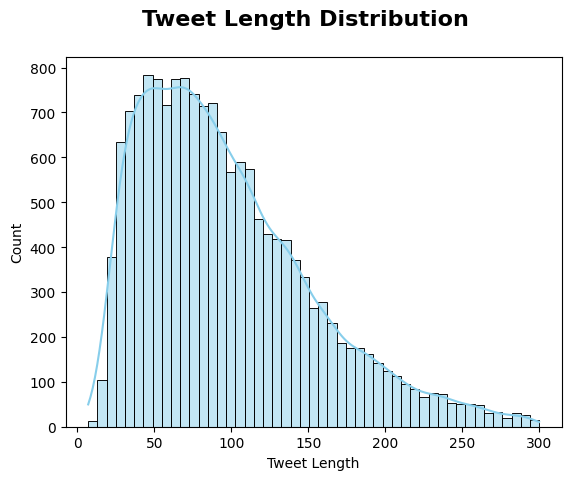

<Axes: xlabel='text_length', ylabel='Count'>

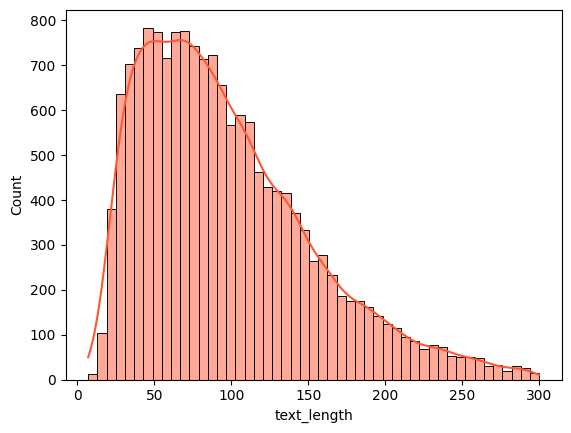

In [ ]:
train['text_length'] = train['text'].astype(str).apply(len)
train['text_word_count'] = train['text'].apply(lambda x: len(str(x).split()))
sns.histplot(train['text_length'], kde=True, color='skyblue')
plt.xlabel('Tweet Length')
plt.suptitle('Tweet Length Distribution', fontweight='heavy', fontsize=16, fontfamily='Verdana')
plt.show()
my_colors = ['#FF5733', '#33FF57', '#3357FF']
sns.histplot(train['text_length'], kde=True, color=my_colors[0])



**Data pre-processing**

In the below function first we are removing URLS and then we check for if there are any mention tags and similar to that hashtags and then we see if we have HTML tags and following punctuation and numbers we preprocess all this data and then we do lemmatization and stopwords removal

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# Initializing stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<\w+', '', text)
    text = re.sub(r'</\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)


df['text_clean'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-28-90464ba6ccea>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df['text'].apply(clean_text)


In [ ]:
df.head()

,text,label,text_clean
0,i didnt feel humiliated,0,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,3,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,3,feeling grouchy


In [ ]:
df_updated = df[['text_clean', 'label']]

Here we are tokenizing the text into sequences of integers with a tokenizer limited to 5000 words it pad sequences to a maximum length of 300

In [ ]:

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_updated['text_clean'].values)
text_clean_encode = tokenizer.texts_to_sequences(df_updated['text_clean'].values)
text_clean_encode_padded = pad_sequences(text_clean_encode, maxlen=300, padding='post')
df_updated['text_clean_encode'] = text_clean_encode_padded.tolist()
df_updated['text_clean_encode'].head()

0    [55, 2, 520, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [31, 3, 413, 2890, 435, 45, 53, 180, 1267, 0, ...
2    [5, 2891, 389, 143, 2, 390, 311, 0, 0, 0, 0, 0...
3    [80, 3, 566, 4371, 8, 20, 3213, 0, 0, 0, 0, 0,...
4    [3, 925, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
Name: text_clean_encode, dtype: object

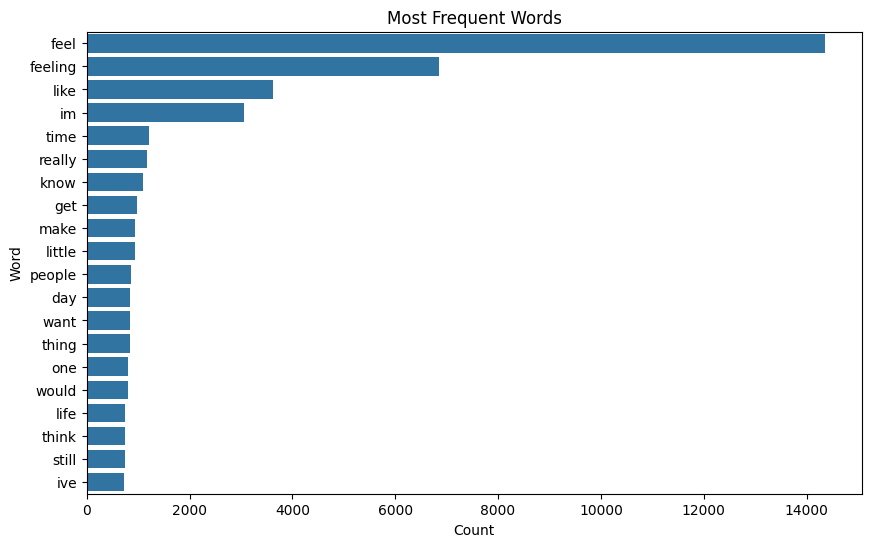

In [ ]:
#checking for the most frequent words
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'count'])
word_freq = word_freq.sort_values(by='count', ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='word', data=word_freq)
plt.title('Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

Splitting the dataset into training, testing and validation sets

In [ ]:
train_df, test_and_val_df = train_test_split(df_updated, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_and_val_df, test_size=0.5, random_state=42)

In [ ]:
test_and_val_df.head()

,text_clean,label,text_clean_encode
10650,noticed several month ago start feeling resent...,3,"[1169, 818, 150, 359, 102, 3, 433, 730, 648, 4..."
2041,love lot different kind sport love hanging fri...,1,"[25, 58, 440, 70, 1957, 25, 1845, 44, 188, 6, ..."
8668,feel even killed agonized extent,0,"[2, 22, 2316, 1, 1669, 0, 0, 0, 0, 0, 0, 0, 0,..."
1114,feel numb way wound really start hurt,0,"[2, 452, 24, 1839, 7, 102, 134, 0, 0, 0, 0, 0,..."
13903,quite outsider due british mentality feeling e...,0,"[64, 2737, 775, 2207, 3632, 3, 312, 1, 1502, 1..."


PyTorch DataLoader Setup for Sentiment Analysis






In [ ]:
from torch.utils.data import DataLoader, Dataset

class createDataset(Dataset):
  def __init__(self, df_internal):
    self.text_clean_encode = list(df_internal['text_clean_encode'])
    self.airline_sentiment = list(df_internal['label'])

  def __len__(self):
    return len(self.text_clean_encode)

  def __getitem__(self, indx):
    return torch.tensor(self.text_clean_encode[indx]), torch.tensor(self.airline_sentiment[indx])


train_dataset = createDataset(train_df)
val_dataset = createDataset(val_df)
test_dataset = createDataset(test_df)

train_loader = DataLoader(train_dataset, num_workers=2, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=2, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, num_workers=2, batch_size=32, shuffle=False)

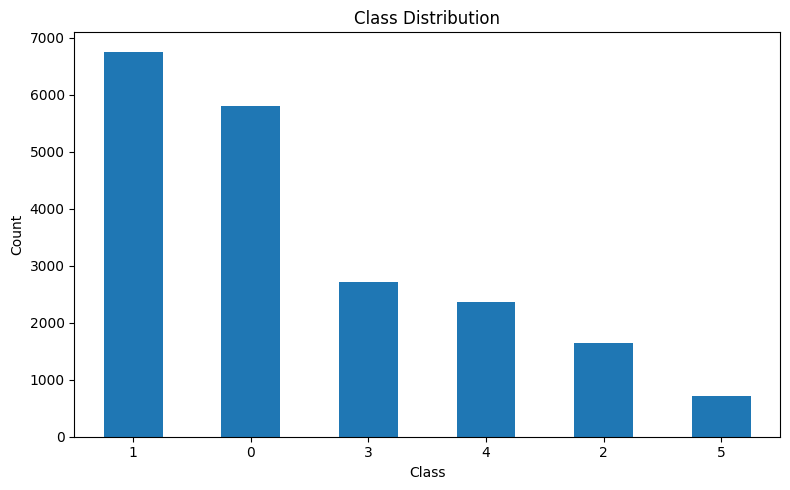

In [ ]:
#Distribution of Classes
import pandas as pd
import matplotlib.pyplot as plt

label_column = 'label'

class_counts = df[label_column].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Building CNN model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Defining the CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 200
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 6
DROPOUT = 0.5

CNN_model = CNNModel(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
CNN_model = CNN_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_model.parameters())

# Training function
def train(CNN_model, iterator, optimizer, criterion):
    CNN_model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        predictions = CNN_model(text)
        loss = criterion(predictions, labels)
        acc = ((predictions.argmax(1) == labels).float().mean())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function
def evaluate(CNN_model, iterator, criterion):
    CNN_model.eval()
    epoch_loss = 0
    epoch_acc = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            outputs = CNN_model(text)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            acc = ((outputs.argmax(1) == labels).float().mean())
            epoch_acc += acc.item()
            predictions.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, true_labels

# Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

N_EPOCHS = 12
train_accuracies_CNN = []
val_accuracies_CNN = []
train_losses_CNN = []
val_losses_CNN = []

for epoch in range(N_EPOCHS):
    train_loss_CNN, train_acc_CNN = train(CNN_model, train_loader, optimizer, criterion)
    val_loss_CNN, val_acc_CNN, _, _ = evaluate(CNN_model, val_loader, criterion)

    train_accuracies_CNN.append(train_acc_CNN)
    val_accuracies_CNN.append(val_acc_CNN)
    train_losses_CNN.append(train_loss_CNN)
    val_losses_CNN.append(val_loss_CNN)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss of CNN model: {train_loss_CNN:.3f} | Train Accuracy of CNN model: {train_acc_CNN*100:.2f}%')
    print(f'\t Val. Loss of CNN model: {val_loss_CNN:.3f} |  Validation Accuracy of CNN model: {val_acc_CNN*100:.2f}%')

# Evaluation on test
test_loss_CNN, test_acc_CNN, test_predictions_CNN, test_true_labels_CNN = evaluate(CNN_model, test_loader, criterion)
print(f'Test Loss of CNN: {test_loss_CNN:.3f} | Test Acc of CNN: {test_acc_CNN*100:.2f}%')




Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 01
	Train Loss of CNN model: 1.397 | Train Accuracy of CNN model: 45.26%
	 Val. Loss of CNN model: 0.824 |  Validation Accuracy of CNN model: 74.88%
Epoch: 02
	Train Loss of CNN model: 0.600 | Train Accuracy of CNN model: 79.20%
	 Val. Loss of CNN model: 0.381 |  Validation Accuracy of CNN model: 86.51%
Epoch: 03
	Train Loss of CNN model: 0.295 | Train Accuracy of CNN model: 90.03%
	 Val. Loss of CNN model: 0.318 |  Validation Accuracy of CNN model: 88.67%
Epoch: 04
	Train Loss of CNN model: 0.192 | Train Accuracy of CNN model: 93.54%
	 Val. Loss of CNN model: 0.331 |  Validation Accuracy of CNN model: 88.38%
Epoch: 05
	Train Loss of CNN model: 0.142 | Train Accuracy of CNN model: 94.91%
	 Val. Loss of CNN model: 0.315 |  Validation Accuracy of CNN model: 89.14%
Epoch: 06
	Train Loss of CNN model: 0.109 | Train Accuracy of CNN model: 96.18%
	 Val. Loss of CNN model: 0.300 |  Validation Accuracy of CNN model: 90.34%
Epoch: 07
	Train Loss of CNN model: 0.094 | Train Accuracy of CN

In [ ]:
precision_CNN = precision_score(test_true_labels_CNN, test_predictions_CNN, average='weighted')
recall_CNN = recall_score(test_true_labels_CNN, test_predictions_CNN, average='weighted')
f1_CNN = f1_score(test_true_labels_CNN, test_predictions_CNN, average='weighted')

print(f'Precision: {precision_CNN:.4f}')
print(f'Recall: {recall_CNN:.4f}')
print(f'F1 Score: {f1_CNN:.4f}')

Precision: 0.9120
Recall: 0.9110
F1 Score: 0.9108


Loss plot saved as 'loss_plot_CNN.png'


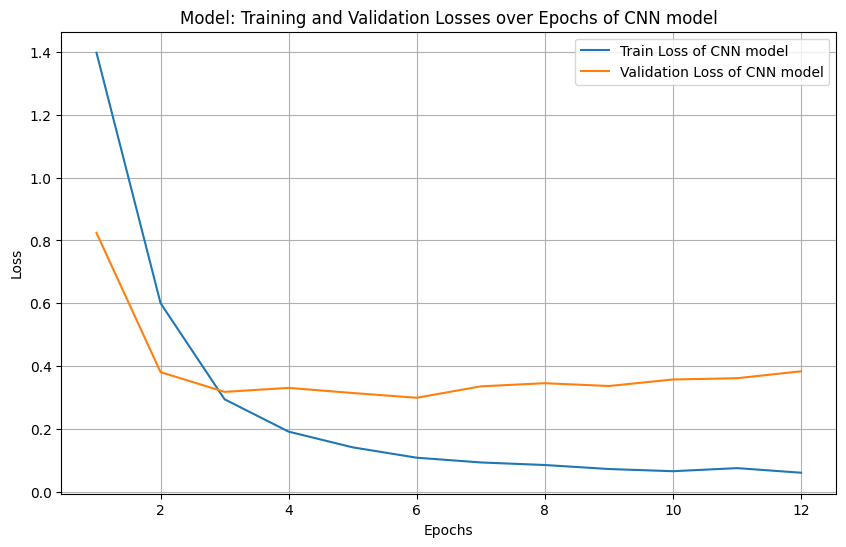

Accuracy plot saved as 'accuracy_plot_CNN.png'


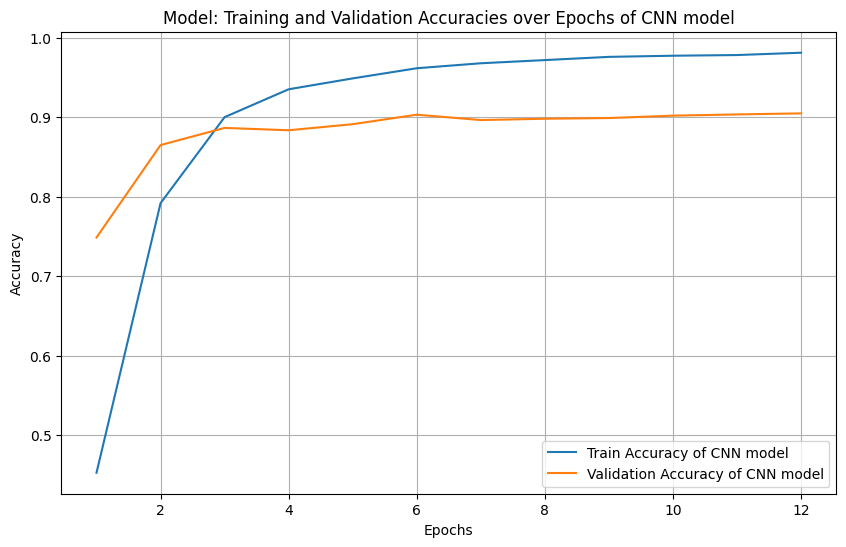

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses_CNN, label='Train Loss of CNN model')
plt.plot(range(1, N_EPOCHS + 1), val_losses_CNN, label='Validation Loss of CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model: Training and Validation Losses over Epochs of CNN model')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_CNN.png')
print("Loss plot saved as 'loss_plot_CNN.png'")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_accuracies_CNN, label='Train Accuracy of CNN model')
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_CNN, label='Validation Accuracy of CNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model: Training and Validation Accuracies over Epochs of CNN model')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot_CNN.png')
print("Accuracy plot saved as 'accuracy_plot_CNN.png'")
plt.show()



Confusion matrix plot saved as 'confusion_matrix_CNN.png'


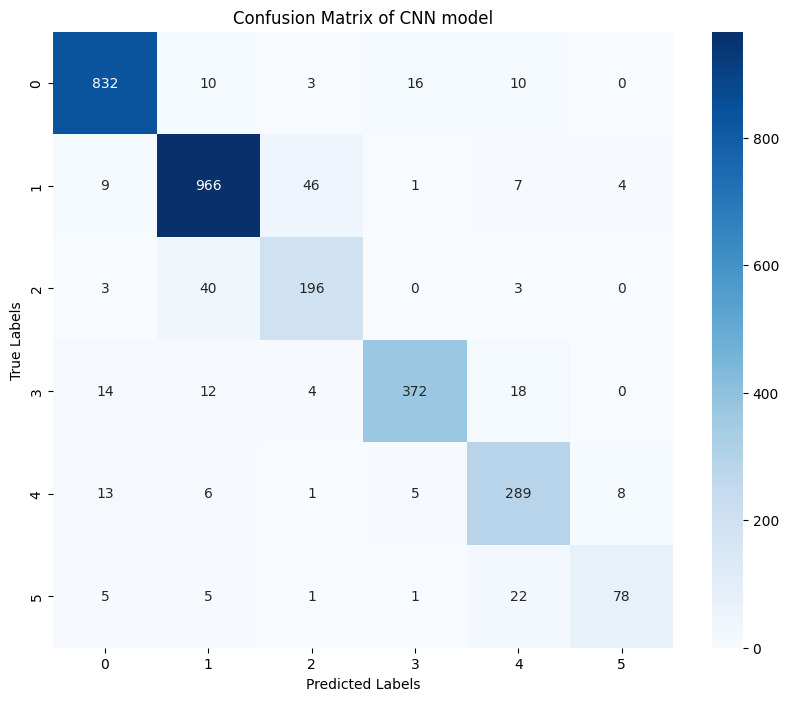

In [ ]:
# Confusion matrix
conf_mat_CNN = confusion_matrix(test_true_labels_CNN, test_predictions_CNN)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_CNN, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of CNN model')
plt.savefig('confusion_matrix_CNN.png')
print("Confusion matrix plot saved as 'confusion_matrix_CNN.png'")
plt.show()

### checking the model predition with examples

In [ ]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def predict_sentiment(texts):
    CNN_model.eval()
    predictions = []

    for text in texts:
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, padding='post', maxlen=50)
        tensor_sequence = torch.LongTensor(padded_sequence).to(device)

        with torch.no_grad():
            output = CNN_model(tensor_sequence)
            predicted_class = output.argmax(axis=1).item()

        predictions.append(class_labels[predicted_class])

    for i, prediction in enumerate(predictions):
        print(f'Text {i+1}: Predicted sentiment is {prediction}')

predict_sentiment(['I would love to talk with my family', 'This movie made me so sad'])


Text 1: Predicted sentiment is joy
Text 2: Predicted sentiment is sadness


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Building LSTM model

Using device: cuda


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01
	Train Loss: 1.584 | Train Acc: 33.27%
	 Val. Loss: 1.581 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 02
	Train Loss: 1.580 | Train Acc: 33.51%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 03
	Train Loss: 1.579 | Train Acc: 33.74%
	 Val. Loss: 1.575 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 04
	Train Loss: 1.579 | Train Acc: 33.41%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 05
	Train Loss: 1.579 | Train Acc: 33.98%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 06
	Train Loss: 1.578 | Train Acc: 33.96%
	 Val. Loss: 1.580 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 07
	Train Loss: 1.577 | Train Acc: 33.92%
	 Val. Loss: 1.579 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 08
	Train Loss: 1.578 | Train Acc: 33.98%
	 Val. Loss: 1.578 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 09
	Train Loss: 1.578 | Train Acc: 33.97%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10
	Train Loss: 1.578 | Train Acc: 33.96%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11
	Train Loss: 1.578 | Train Acc: 33.98%
	 Val. Loss: 1.580 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12
	Train Loss: 1.577 | Train Acc: 34.03%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% | Val. Precision: 0.104 | Val. Recall: 0.322 | Val. F1: 0.157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1.569 | Test Acc: 34.42% | Test Precision: 0.119 | Test Recall: 0.344 | Test F1: 0.176
Loss plot saved as 'loss_plot_lstm.png'


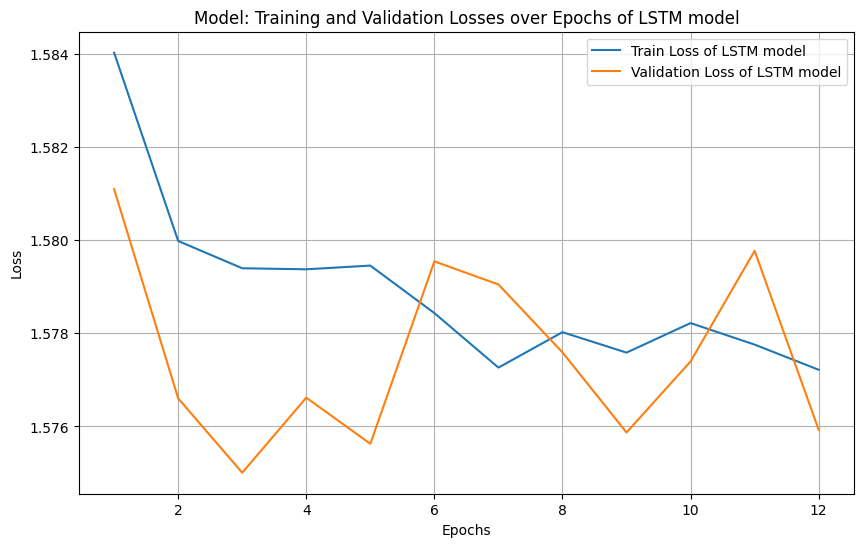

Accuracy plot saved as 'accuracy_plot_lstm.png'


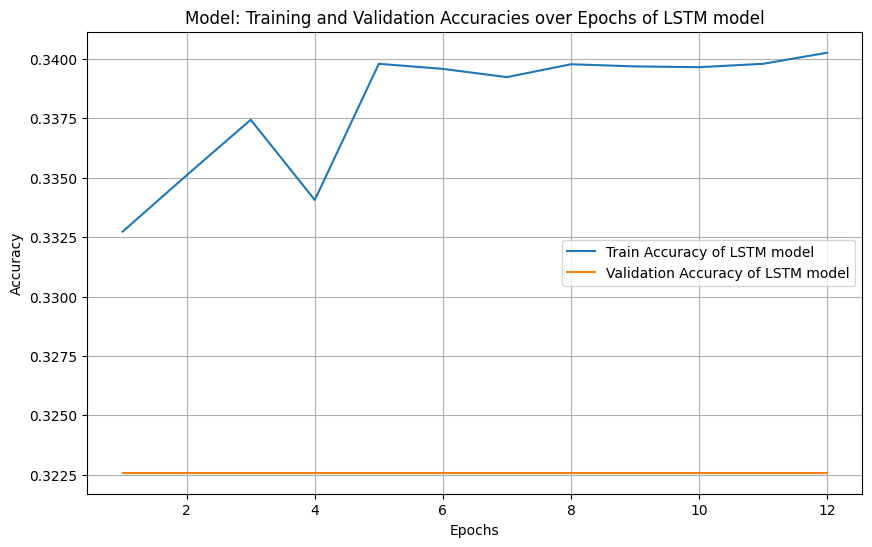

Confusion matrix plot saved as 'confusion_matrix_lstm.png'


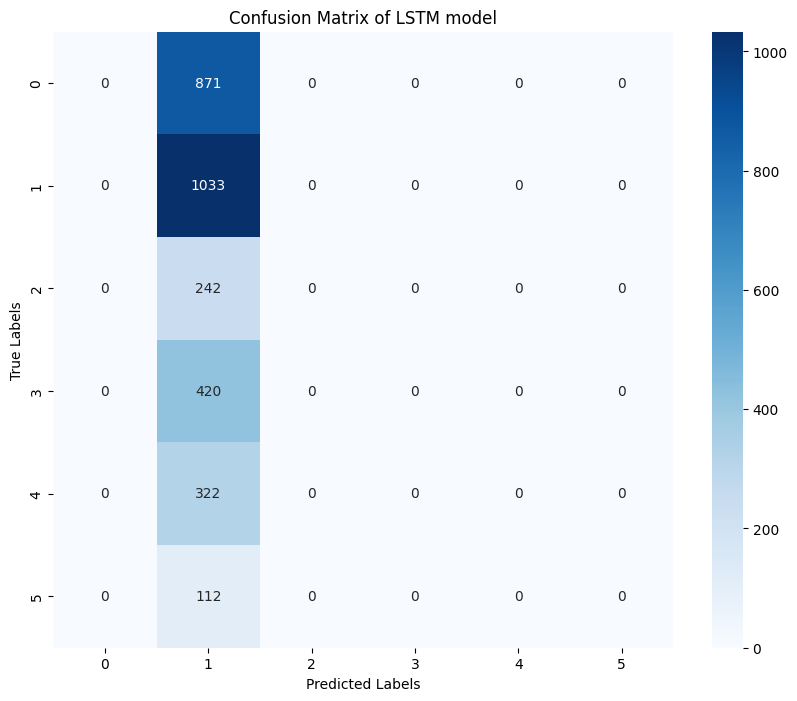

In [ ]:


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

# Hyperparameters
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 6
N_LAYERS = 4
DROPOUT = 0.25

print(*)

LSTM_model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
LSTM_model = LSTM_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LSTM_model.parameters())

# Training phase
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()

        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text)

        loss = criterion(predictions, labels)
        acc = ((predictions.argmax(1) == labels).float().mean())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    predictions_lstm = []
    true_labels_lstm = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            outputs = model(text)

            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            acc = ((outputs.argmax(1) == labels).float().mean())
            epoch_acc += acc.item()
            predictions_lstm.extend(outputs.argmax(1).cpu().numpy())
            true_labels_lstm.extend(labels.cpu().numpy())

        precision_lstm = precision_score(true_labels_lstm, predictions_lstm, average='weighted')
        recall_lstm = recall_score(true_labels_lstm, predictions_lstm, average='weighted')
        f1_lstm = f1_score(true_labels_lstm, predictions_lstm, average='weighted')

    return epoch_loss / len(iterator), epoch_acc / len(iterator), precision_lstm, recall_lstm, f1_lstm, predictions_lstm, true_labels_lstm

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


N_EPOCHS = 12
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []

for epoch in range(N_EPOCHS):
    train_loss_lstm, train_acc_lstm = train(LSTM_model, train_loader, optimizer, criterion)
    val_loss_lstm, val_acc_lstm, val_precision_lstm, val_recall_lstm, val_f1_lstm, _, _ = evaluate(LSTM_model, val_loader, criterion)

    train_accuracies_lstm.append(train_acc_lstm)
    val_accuracies_lstm.append(val_acc_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss_lstm:.3f} | Train Acc: {train_acc_lstm*100:.2f}%')
    print(f'\t Val. Loss: {val_loss_lstm:.3f} |  Val. Acc: {val_acc_lstm*100:.2f}% | Val. Precision: {val_precision_lstm:.3f} | Val. Recall: {val_recall_lstm:.3f} | Val. F1: {val_f1_lstm:.3f}')

test_loss_lstm, test_acc_lstm, test_precision_lstm, test_recall_lstm, test_f1_score_lstm, test_predictions_lstm, test_true_labels_lstm = evaluate(LSTM_model, test_loader, criterion)
print(f'Test Loss: {test_loss_lstm:.3f} | Test Acc: {test_acc_lstm*100:.2f}% | Test Precision: {test_precision_lstm:.3f} | Test Recall: {test_recall_lstm:.3f} | Test F1: {test_f1_score_lstm:.3f}')


#visulization of loss and accuracy based on epochs
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses_lstm, label='Train Loss of LSTM model')
plt.plot(range(1, N_EPOCHS + 1), val_losses_lstm, label='Validation Loss of LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model: Training and Validation Losses over Epochs of LSTM model')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_lstm.png')
print("Loss plot saved as 'loss_plot_lstm.png'")
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_accuracies_lstm, label='Train Accuracy of LSTM model')
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_lstm, label='Validation Accuracy of LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model: Training and Validation Accuracies over Epochs of LSTM model')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot_lstm.png')
print("Accuracy plot saved as 'accuracy_plot_lstm.png'")
plt.show()

# Confusion matrix
conf_mat_lstm = confusion_matrix(test_true_labels_lstm, test_predictions_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of LSTM model')
plt.savefig('confusion_matrix_lstm.png')
print("Confusion matrix plot saved as 'confusion_matrix_lstm.png'")
plt.show()



### checking the model prediction with examples

In [ ]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def predict_sentiment(texts):
    LSTM_model.eval()
    predictions = []

    for text in texts:
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, padding='post', maxlen=50)
        tensor_sequence = torch.LongTensor(padded_sequence).to(device)

        with torch.no_grad():
            output = LSTM_model(tensor_sequence)
            predicted_class = output.argmax(axis=1).item()

        predictions.append(class_labels[predicted_class])

    for i, prediction in enumerate(predictions):
        print(f'Text {i+1}: Predicted sentiment is {prediction}')

predict_sentiment(['I hate to call', 'This movie made me so sad'])


Text 1: Predicted sentiment is joy
Text 2: Predicted sentiment is joy


Experimenting with different Parameters to Improve the model performance of lSTM

---



Using device: cuda

Training and Evaluating LSTM Model with Hyperparameters: {'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01
	Train Loss: 1.587 | Train Acc: 32.95%
	 Val. Loss: 1.579 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 02
	Train Loss: 1.581 | Train Acc: 33.32%
	 Val. Loss: 1.578 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 03
	Train Loss: 1.581 | Train Acc: 34.03%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 04
	Train Loss: 1.579 | Train Acc: 33.65%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 05
	Train Loss: 1.579 | Train Acc: 33.83%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 06
	Train Loss: 1.578 | Train Acc: 33.90%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 07
	Train Loss: 1.577 | Train Acc: 33.99%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 08
	Train Loss: 1.579 | Train Acc: 33.97%
	 Val. Loss: 1.575 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 09
	Train Loss: 1.578 | Train Acc: 33.74%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10
	Train Loss: 1.578 | Train Acc: 34.04%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11
	Train Loss: 1.578 | Train Acc: 33.94%
	 Val. Loss: 1.580 |  Val. Acc: 32.23% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12
	Train Loss: 1.579 | Train Acc: 34.02%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1.569 | Test Acc: 34.42% | Test Precision: 0.119 | Test Recall: 0.344 | Test F1: 0.176
Loss plot saved as 'loss_plot_lstm_128_3_0.3.png'


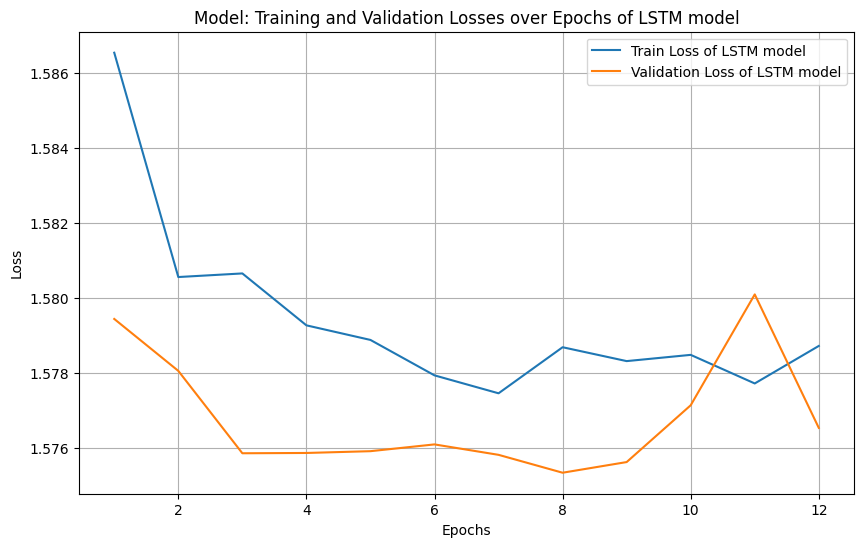

Accuracy plot saved as 'accuracy_plot_lstm_128_3_0.3.png'


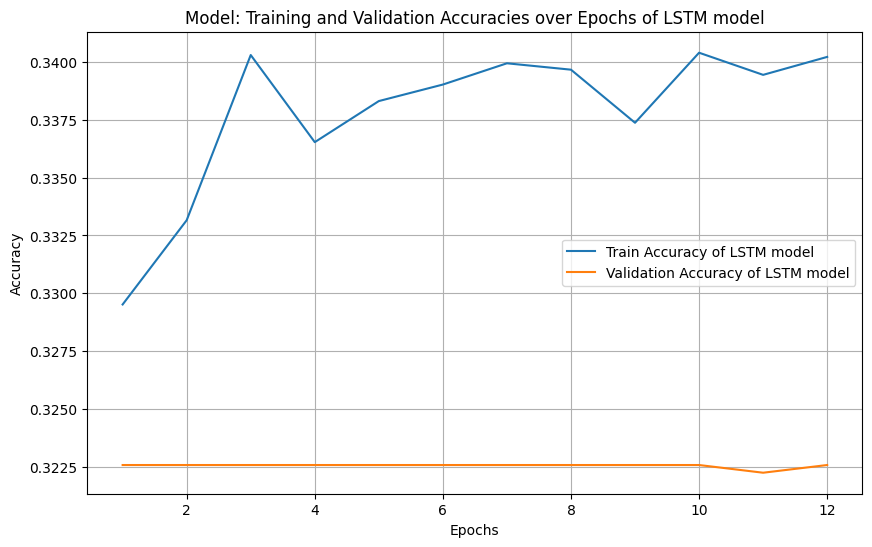

Confusion matrix plot saved as 'confusion_matrix_lstm_128_3_0.3.png'


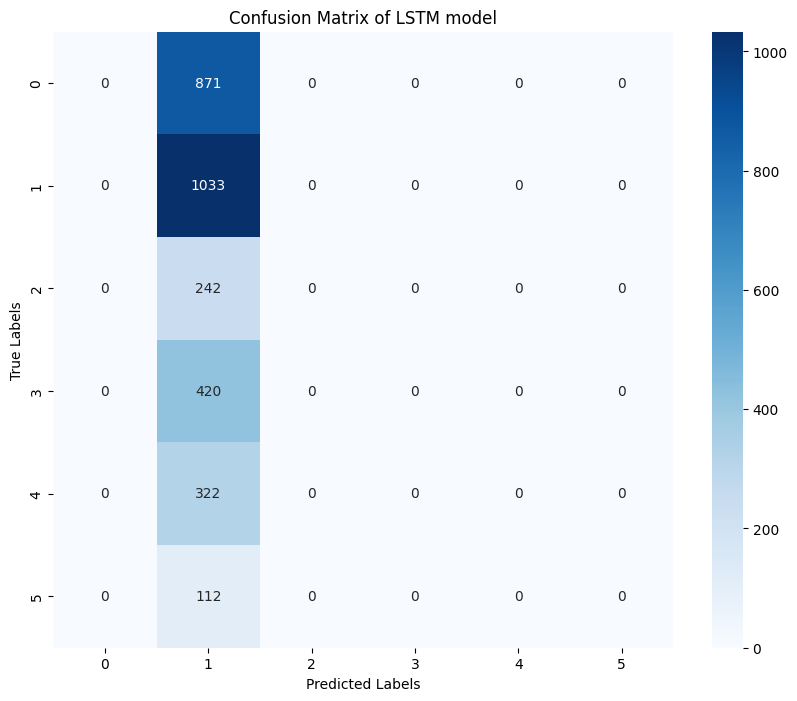


Training and Evaluating LSTM Model with Hyperparameters: {'hidden_dim': 512, 'n_layers': 2, 'dropout': 0.2}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01
	Train Loss: 1.582 | Train Acc: 33.40%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 02
	Train Loss: 1.579 | Train Acc: 33.49%
	 Val. Loss: 1.582 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 03
	Train Loss: 1.578 | Train Acc: 34.05%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 04
	Train Loss: 1.578 | Train Acc: 33.76%
	 Val. Loss: 1.579 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 05
	Train Loss: 1.579 | Train Acc: 33.65%
	 Val. Loss: 1.578 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 06
	Train Loss: 1.578 | Train Acc: 34.00%
	 Val. Loss: 1.579 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 07
	Train Loss: 1.578 | Train Acc: 33.77%
	 Val. Loss: 1.579 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 08
	Train Loss: 1.578 | Train Acc: 33.90%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 09
	Train Loss: 1.578 | Train Acc: 33.94%
	 Val. Loss: 1.579 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10
	Train Loss: 1.579 | Train Acc: 34.00%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11
	Train Loss: 1.577 | Train Acc: 34.01%
	 Val. Loss: 1.575 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12
	Train Loss: 1.577 | Train Acc: 34.00%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1.571 | Test Acc: 34.42% | Test Precision: 0.119 | Test Recall: 0.344 | Test F1: 0.176
Loss plot saved as 'loss_plot_lstm_512_2_0.2.png'


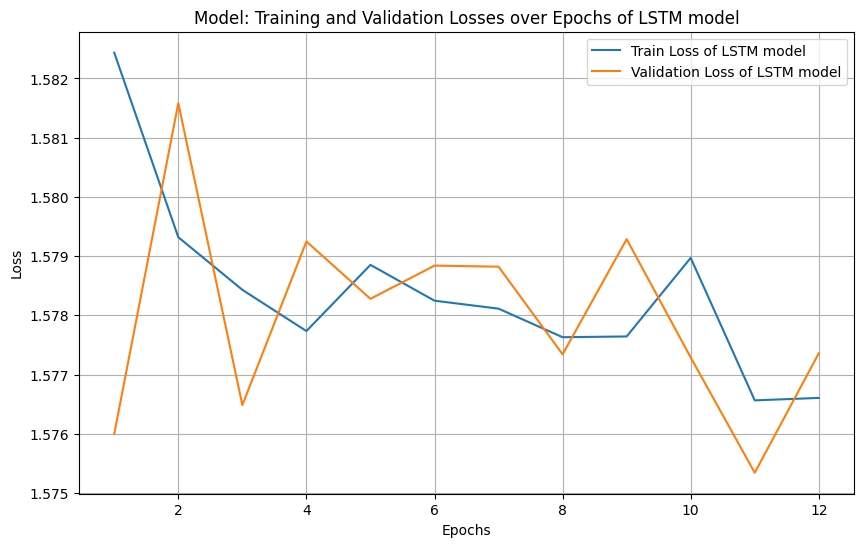

Accuracy plot saved as 'accuracy_plot_lstm_512_2_0.2.png'


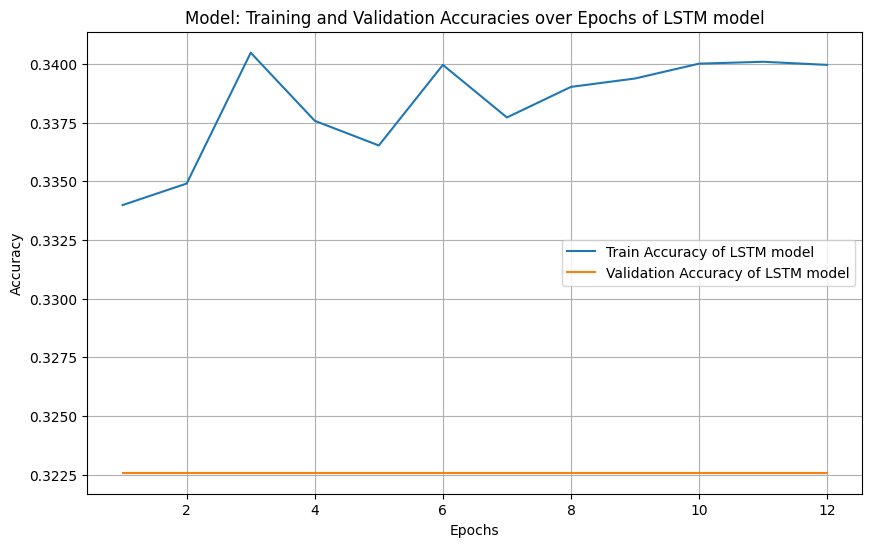

Confusion matrix plot saved as 'confusion_matrix_lstm_512_2_0.2.png'


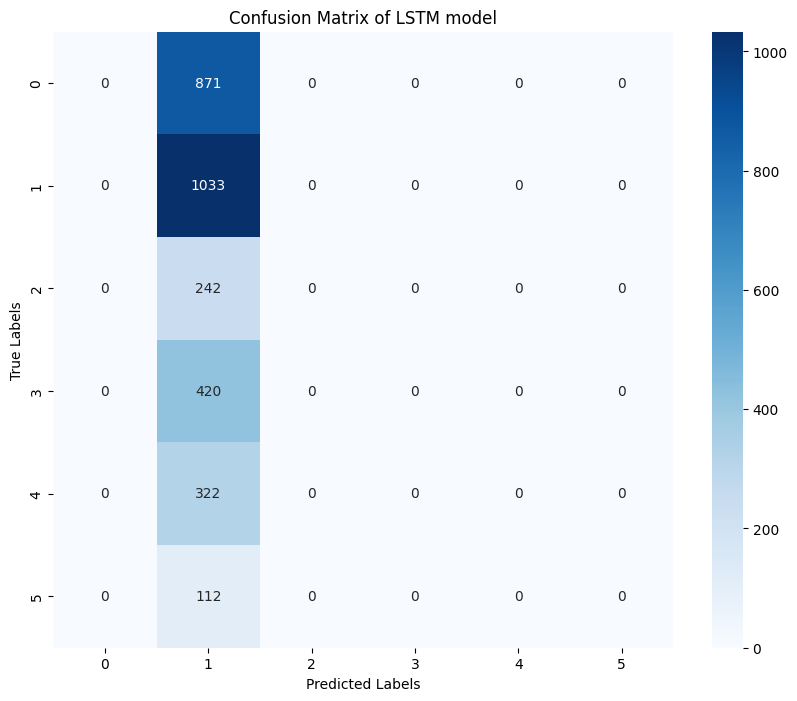


Training and Evaluating LSTM Model with Hyperparameters: {'hidden_dim': 128, 'n_layers': 5, 'dropout': 0.4}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01
	Train Loss: 1.588 | Train Acc: 32.72%
	 Val. Loss: 1.575 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 02
	Train Loss: 1.582 | Train Acc: 33.53%
	 Val. Loss: 1.579 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 03
	Train Loss: 1.580 | Train Acc: 33.54%
	 Val. Loss: 1.578 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 04
	Train Loss: 1.580 | Train Acc: 33.93%
	 Val. Loss: 1.578 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 05
	Train Loss: 1.579 | Train Acc: 33.93%
	 Val. Loss: 1.576 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 06
	Train Loss: 1.579 | Train Acc: 33.75%
	 Val. Loss: 1.580 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 07
	Train Loss: 1.578 | Train Acc: 33.60%
	 Val. Loss: 1.583 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 08
	Train Loss: 1.579 | Train Acc: 33.83%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 09
	Train Loss: 1.578 | Train Acc: 33.92%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10
	Train Loss: 1.578 | Train Acc: 33.99%
	 Val. Loss: 1.575 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11
	Train Loss: 1.578 | Train Acc: 34.02%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12
	Train Loss: 1.579 | Train Acc: 33.96%
	 Val. Loss: 1.577 |  Val. Acc: 32.26% 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1.569 | Test Acc: 34.42% | Test Precision: 0.119 | Test Recall: 0.344 | Test F1: 0.176
Loss plot saved as 'loss_plot_lstm_128_5_0.4.png'


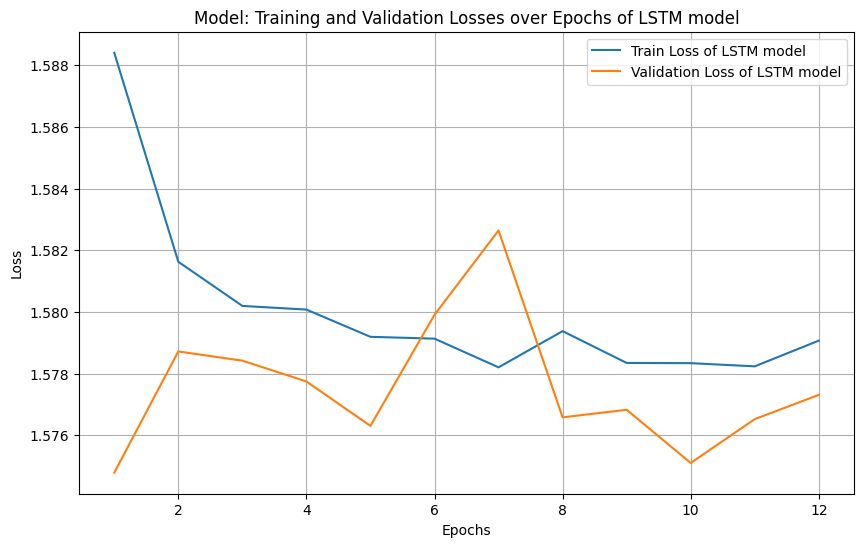

Accuracy plot saved as 'accuracy_plot_lstm_128_5_0.4.png'


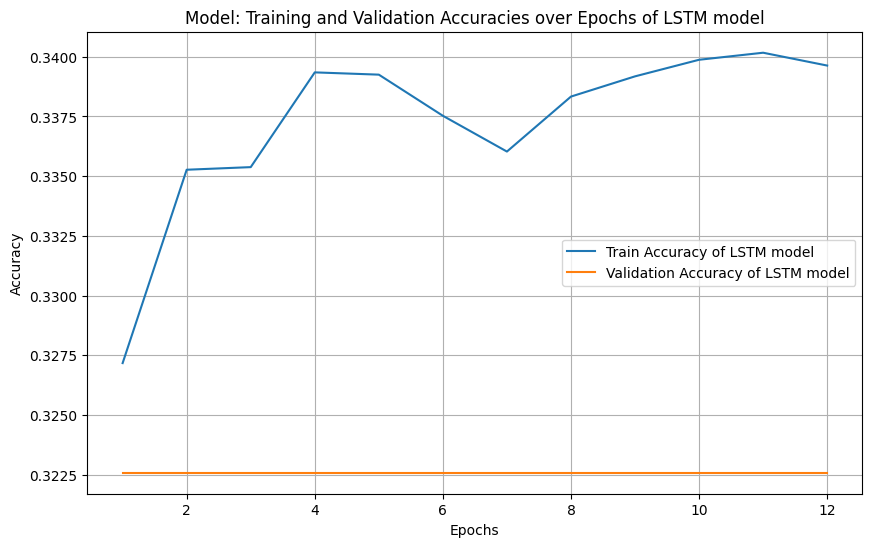

Confusion matrix plot saved as 'confusion_matrix_lstm_128_5_0.4.png'


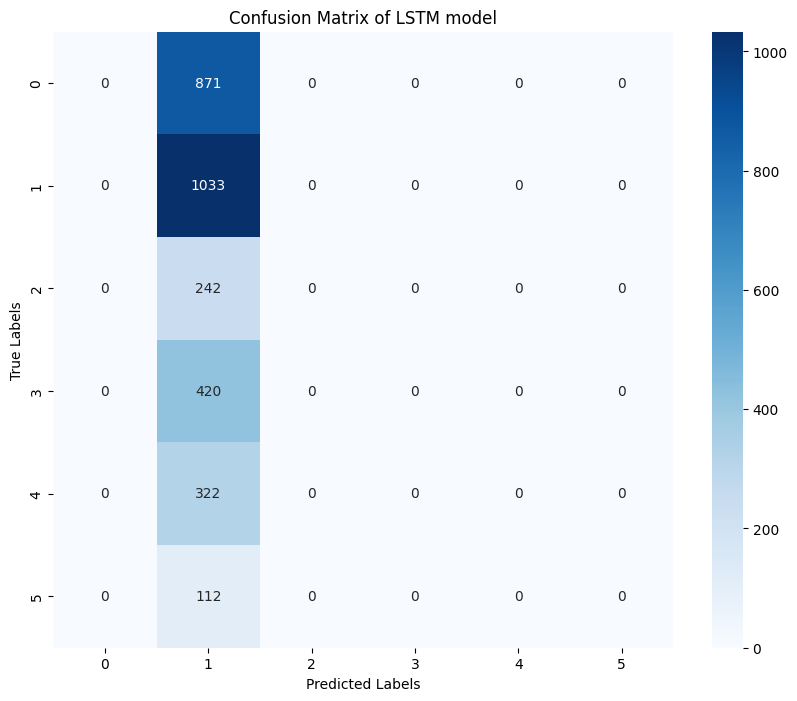

In [ ]:


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_evaluate_lstm(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, train_loader, val_loader, test_loader, num_epochs=12):
    LSTM_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
    LSTM_model = LSTM_model.to(device)

    #  loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(LSTM_model.parameters())

    # Training phase
    def train(model, iterator, optimizer, criterion):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        for batch in iterator:
            optimizer.zero_grad()

            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)

            loss = criterion(predictions, labels)
            acc = ((predictions.argmax(1) == labels).float().mean())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate(model, iterator, criterion):
        model.eval()
        epoch_loss = 0
        epoch_acc = 0
        predictions_lstm = []
        true_labels_lstm = []

        with torch.no_grad():
            for batch in iterator:
                text, labels = batch
                text, labels = text.to(device), labels.to(device)

                outputs = model(text)

                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                acc = ((outputs.argmax(1) == labels).float().mean())
                epoch_acc += acc.item()
                predictions_lstm.extend(outputs.argmax(1).cpu().numpy())
                true_labels_lstm.extend(labels.cpu().numpy())

            precision_lstm = precision_score(true_labels_lstm, predictions_lstm, average='weighted')
            recall_lstm = recall_score(true_labels_lstm, predictions_lstm, average='weighted')
            f1_lstm = f1_score(true_labels_lstm, predictions_lstm, average='weighted')

        return epoch_loss / len(iterator), epoch_acc / len(iterator), precision_lstm, recall_lstm, f1_lstm, predictions_lstm, true_labels_lstm

    train_accuracies_lstm = []
    val_accuracies_lstm = []
    train_losses_lstm = []
    val_losses_lstm = []

    for epoch in range(num_epochs):
        train_loss_lstm, train_acc_lstm = train(LSTM_model, train_loader, optimizer, criterion)
        val_loss_lstm, val_acc_lstm, val_precision_lstm, val_recall_lstm, val_f1_lstm, _, _ = evaluate(LSTM_model, val_loader, criterion)

        train_accuracies_lstm.append(train_acc_lstm)
        val_accuracies_lstm.append(val_acc_lstm)
        train_losses_lstm.append(train_loss_lstm)
        val_losses_lstm.append(val_loss_lstm)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss_lstm:.3f} | Train Acc: {train_acc_lstm*100:.2f}%')
        print(f'\t Val. Loss: {val_loss_lstm:.3f} |  Val. Acc: {val_acc_lstm*100:.2f}% ')

    test_loss_lstm, test_acc_lstm, test_precision_lstm, test_recall_lstm, test_f1_score_lstm, test_predictions_lstm, test_true_labels_lstm = evaluate(LSTM_model, test_loader, criterion)
    print(f'Test Loss: {test_loss_lstm:.3f} | Test Acc: {test_acc_lstm*100:.2f}% | Test Precision: {test_precision_lstm:.3f} | Test Recall: {test_recall_lstm:.3f} | Test F1: {test_f1_score_lstm:.3f}')

    ##plotting loss and accuracies over epochs
    # Plotting the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses_lstm, label='Train Loss of LSTM model')
    plt.plot(range(1, num_epochs + 1), val_losses_lstm, label='Validation Loss of LSTM model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model: Training and Validation Losses over Epochs of LSTM model')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_lstm_{hidden_dim}_{n_layers}_{dropout}.png')
    print(f"Loss plot saved as 'loss_plot_lstm_{hidden_dim}_{n_layers}_{dropout}.png'")
    plt.show()

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies_lstm, label='Train Accuracy of LSTM model')
    plt.plot(range(1, num_epochs + 1), val_accuracies_lstm, label='Validation Accuracy of LSTM model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model: Training and Validation Accuracies over Epochs of LSTM model')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_plot_lstm_{hidden_dim}_{n_layers}_{dropout}.png')
    print(f"Accuracy plot saved as 'accuracy_plot_lstm_{hidden_dim}_{n_layers}_{dropout}.png'")
    plt.show()

    # Confusion matrix
    conf_mat_lstm = confusion_matrix(test_true_labels_lstm, test_predictions_lstm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat_lstm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix of LSTM model')
    plt.savefig(f'confusion_matrix_lstm_{hidden_dim}_{n_layers}_{dropout}.png')
    print(f"Confusion matrix plot saved as 'confusion_matrix_lstm_{hidden_dim}_{n_layers}_{dropout}.png'")
    plt.show()
#different hyperparameters setting
hyperparams_configurations = [
    {'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3},
    {'hidden_dim': 512, 'n_layers': 2, 'dropout': 0.2},
    {'hidden_dim': 128, 'n_layers': 5, 'dropout': 0.4}
]

for config in hyperparams_configurations:
    print(f"\nTraining and Evaluating LSTM Model with Hyperparameters: {config}")
    train_evaluate_lstm(VOCAB_SIZE, EMBEDDING_DIM, config['hidden_dim'], OUTPUT_DIM, config['n_layers'], config['dropout'], train_loader, val_loader, test_loader)


Implementing the GRU model

Using device: cuda
Epoch: 01
	Train Loss of GRU model: 1.665 | Train Accuracy of GRU model: 30.87%
	 Val. Loss of GRU model: 1.645 |  Validation Accuracy of GRU model: 32.26%
Epoch: 02
	Train Loss of GRU model: 1.630 | Train Accuracy of GRU model: 32.16%
	 Val. Loss of GRU model: 1.594 |  Validation Accuracy of GRU model: 30.94%
Epoch: 03
	Train Loss of GRU model: 1.622 | Train Accuracy of GRU model: 31.95%
	 Val. Loss of GRU model: 1.585 |  Validation Accuracy of GRU model: 31.01%
Epoch: 04
	Train Loss of GRU model: 1.617 | Train Accuracy of GRU model: 32.46%
	 Val. Loss of GRU model: 1.584 |  Validation Accuracy of GRU model: 32.29%
Epoch: 05
	Train Loss of GRU model: 1.618 | Train Accuracy of GRU model: 32.16%
	 Val. Loss of GRU model: 1.653 |  Validation Accuracy of GRU model: 34.04%
Epoch: 06
	Train Loss of GRU model: 1.643 | Train Accuracy of GRU model: 31.11%
	 Val. Loss of GRU model: 1.595 |  Validation Accuracy of GRU model: 32.40%
Epoch: 07
	Train Loss of GRU model: 1.611 | T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

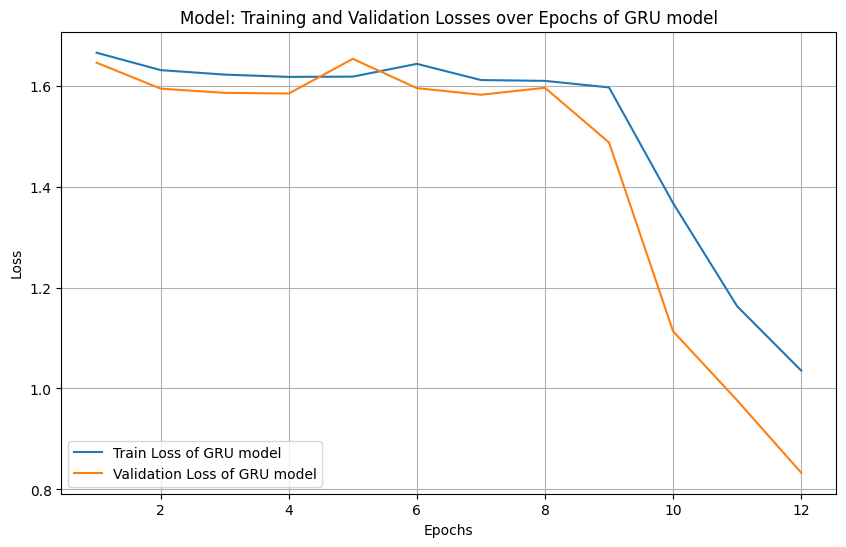

Accuracy plot saved as 'accuracy_plot_GRU.png'


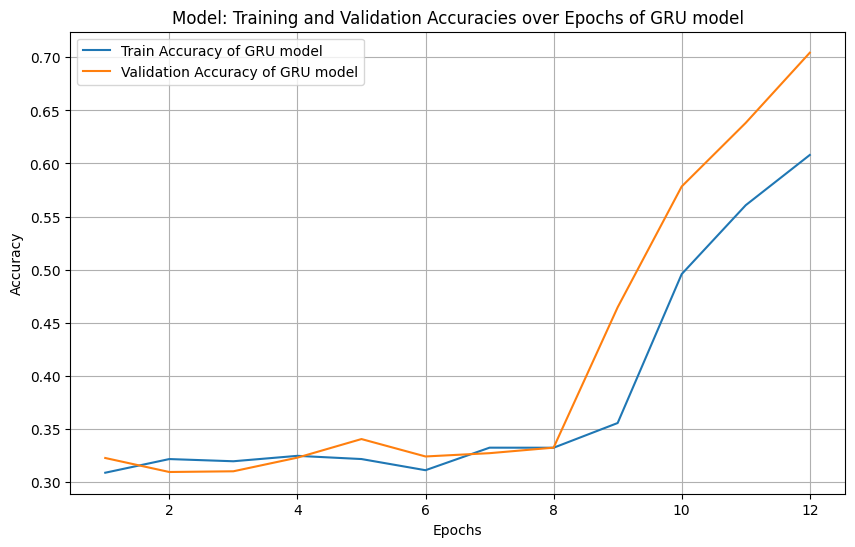

Confusion matrix plot saved as 'confusion_matrix_GRU.png'


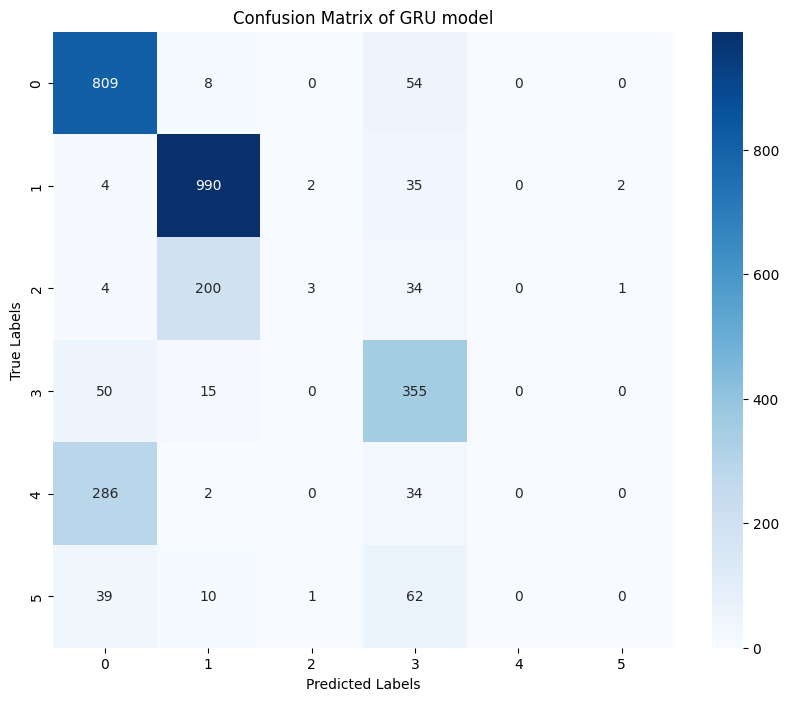

In [ ]:


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 200
HIDDEN_DIM = 512
OUTPUT_DIM = 6
N_LAYERS = 4
DROPOUT = 0.5

GRU_model = GRUModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
GRU_model = GRU_model.to(device)

#  loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(GRU_model.parameters())

# Training phase
def train(GRU_model, iterator, optimizer, criterion):
    GRU_model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        predictions = GRU_model(text)
        loss = criterion(predictions, labels)
        acc = ((predictions.argmax(1) == labels).float().mean())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(GRU_model, iterator, criterion):
    GRU_model.eval()
    epoch_loss = 0
    epoch_acc = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            outputs = GRU_model(text)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            acc = ((outputs.argmax(1) == labels).float().mean())
            epoch_acc += acc.item()
            predictions.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, true_labels

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

N_EPOCHS = 12
train_accuracies_GRU = []
val_accuracies_GRU = []
train_losses_GRU = []
val_losses_GRU = []

for epoch in range(N_EPOCHS):
    train_loss_GRU, train_acc_GRU = train(GRU_model, train_loader, optimizer, criterion)
    val_loss_GRU, val_acc_GRU, _, _ = evaluate(GRU_model, val_loader, criterion)

    train_accuracies_GRU.append(train_acc_GRU)
    val_accuracies_GRU.append(val_acc_GRU)
    train_losses_GRU.append(train_loss_GRU)
    val_losses_GRU.append(val_loss_GRU)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss of GRU model: {train_loss_GRU:.3f} | Train Accuracy of GRU model: {train_acc_GRU*100:.2f}%')
    print(f'\t Val. Loss of GRU model: {val_loss_GRU:.3f} |  Validation Accuracy of GRU model: {val_acc_GRU*100:.2f}%')

test_loss_GRU, test_acc_GRU, test_predictions_GRU, test_true_labels_GRU = evaluate(GRU_model, test_loader, criterion)
print(f'Test Loss of GRU: {test_loss_GRU:.3f} | Test Acc of GRU: {test_acc_GRU*100:.2f}%')

classification_report_GRU = classification_report(test_true_labels_GRU, test_predictions_GRU, output_dict=True)
print("Classification Report for GRU Model:\n")
print(classification_report(test_true_labels_GRU, test_predictions_GRU))

precision_GRU = classification_report_GRU['weighted avg']['precision']
recall_GRU = classification_report_GRU['weighted avg']['recall']
f1_score_GRU = classification_report_GRU['weighted avg']['f1-score']

print(f"Precision: {precision_GRU:.4f}")
print(f"Recall: {recall_GRU:.4f}")
print(f"F1 Score: {f1_score_GRU:.4f}")

#visulization of loss and accuracy based on epochs
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses_GRU, label='Train Loss of GRU model')
plt.plot(range(1, N_EPOCHS + 1), val_losses_GRU, label='Validation Loss of GRU model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model: Training and Validation Losses over Epochs of GRU model')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_GRU.png')
print("Loss plot saved as 'loss_plot_GRU.png'")
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_accuracies_GRU, label='Train Accuracy of GRU model')
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_GRU, label='Validation Accuracy of GRU model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model: Training and Validation Accuracies over Epochs of GRU model')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot_GRU.png')
print("Accuracy plot saved as 'accuracy_plot_GRU.png'")
plt.show()

# Confusion matrix
conf_mat_GRU = confusion_matrix(test_true_labels_GRU, test_predictions_GRU)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_GRU, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of GRU model')
plt.savefig('confusion_matrix_GRU.png')
print("Confusion matrix plot saved as 'confusion_matrix_GRU.png'")
plt.show()


Predicting with example text with the model

In [ ]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def predict_sentiment(texts):
    GRU_model.eval()
    predictions = []

    for text in texts:
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, padding='post', maxlen=50)
        tensor_sequence = torch.LongTensor(padded_sequence).to(device)

        with torch.no_grad():
            output = GRU_model(tensor_sequence)
            predicted_class = output.argmax(axis=1).item()
        predictions.append(class_labels[predicted_class])
    for i, prediction in enumerate(predictions):
        print(f'Text {i+1}: Predicted sentiment is {prediction}')

predict_sentiment(['i did not really feel that embarrassed', 'This movie made me so happy'])


Text 1: Predicted sentiment is sadness
Text 2: Predicted sentiment is anger


Experimenting with different Paramters for the GRU model


Configuration 1: {'EMBEDDING_DIM': 128, 'HIDDEN_DIM': 256, 'DROPOUT': 0.3, 'N_LAYERS': 2}
Epoch: 01
	Train Loss: 1.601 | Train Acc: 32.61%
	 Val. Loss: 1.571 |  Val. Acc: 32.26%
Epoch: 02
	Train Loss: 1.435 | Train Acc: 37.76%
	 Val. Loss: 1.211 |  Val. Acc: 44.47%
Epoch: 03
	Train Loss: 1.081 | Train Acc: 54.04%
	 Val. Loss: 0.698 |  Val. Acc: 73.55%
Epoch: 04
	Train Loss: 0.562 | Train Acc: 79.65%
	 Val. Loss: 0.311 |  Val. Acc: 87.83%
Epoch: 05
	Train Loss: 0.315 | Train Acc: 88.53%
	 Val. Loss: 0.248 |  Val. Acc: 90.39%
Epoch: 06
	Train Loss: 0.228 | Train Acc: 91.47%
	 Val. Loss: 0.228 |  Val. Acc: 90.25%
Epoch: 07
	Train Loss: 0.178 | Train Acc: 92.94%
	 Val. Loss: 0.217 |  Val. Acc: 91.25%
Epoch: 08
	Train Loss: 0.149 | Train Acc: 94.05%
	 Val. Loss: 0.201 |  Val. Acc: 91.59%
Epoch: 09
	Train Loss: 0.133 | Train Acc: 94.55%
	 Val. Loss: 0.200 |  Val. Acc: 92.48%
Epoch: 10
	Train Loss: 0.112 | Train Acc: 95.63%
	 Val. Loss: 0.199 |  Val. Acc: 92.08%
Epoch: 11
	Train Loss: 0.107 

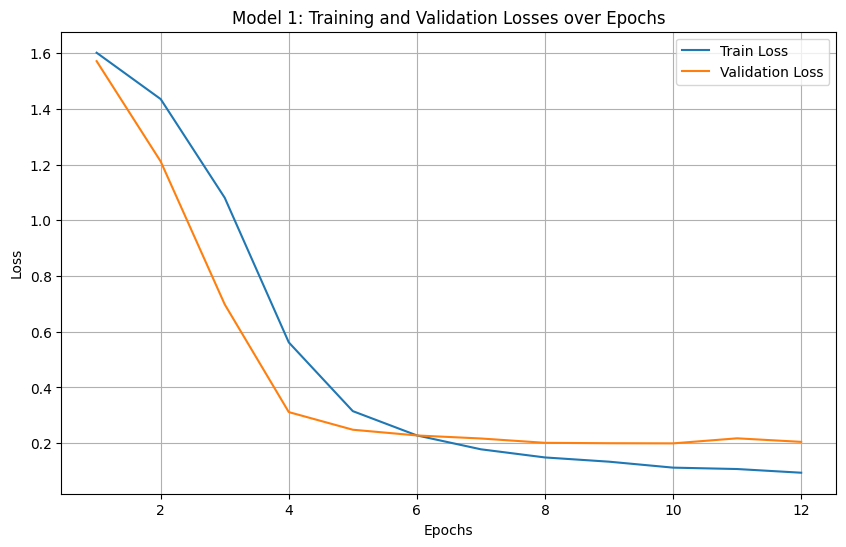

Accuracy plot for Configuration 1 saved as 'accuracy_plot_GRU_config_1.png'


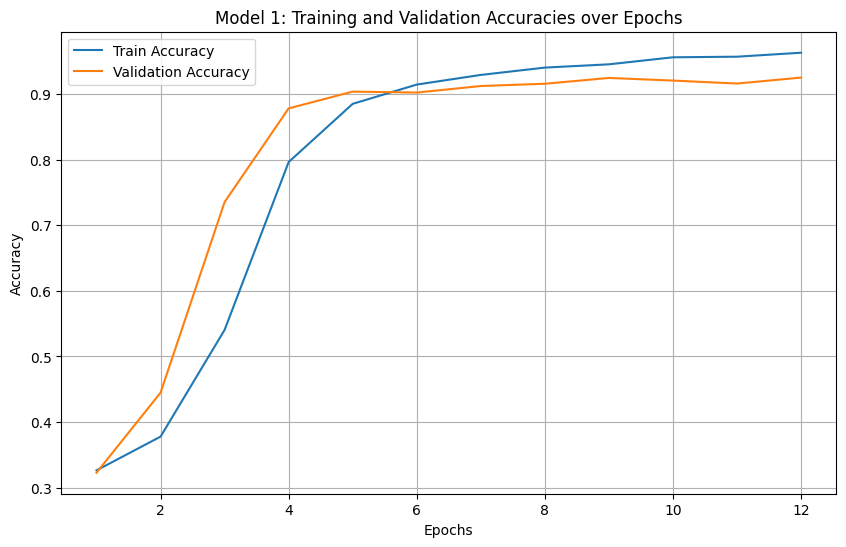

Confusion matrix for Configuration 1 saved as 'confusion_matrix_GRU_config_1.png'


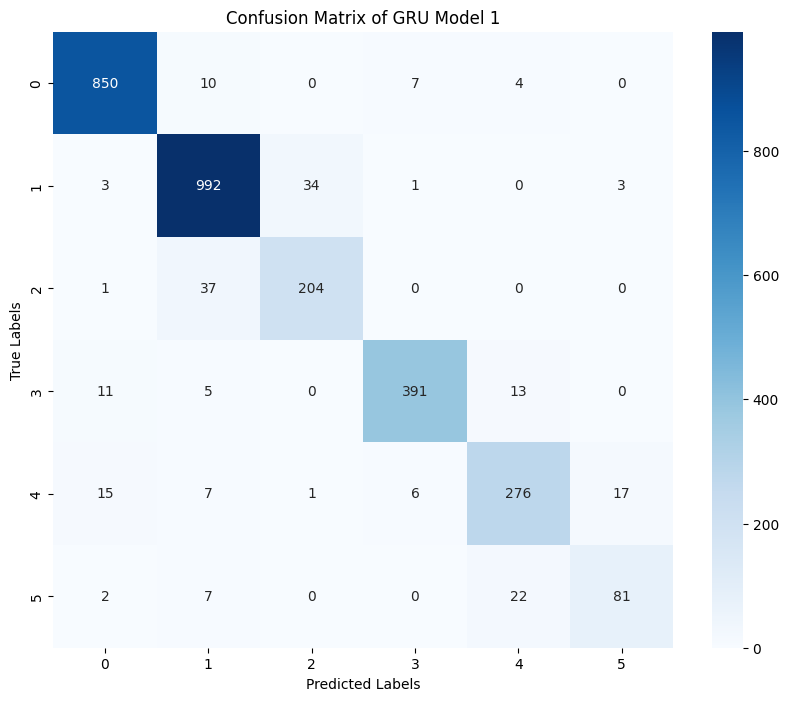


Configuration 2: {'EMBEDDING_DIM': 150, 'HIDDEN_DIM': 300, 'DROPOUT': 0.25, 'N_LAYERS': 2}
Epoch: 01
	Train Loss: 1.589 | Train Acc: 34.24%
	 Val. Loss: 1.485 |  Val. Acc: 46.62%
Epoch: 02
	Train Loss: 1.116 | Train Acc: 59.86%
	 Val. Loss: 0.582 |  Val. Acc: 79.36%
Epoch: 03
	Train Loss: 0.513 | Train Acc: 82.11%
	 Val. Loss: 0.323 |  Val. Acc: 86.87%
Epoch: 04
	Train Loss: 0.288 | Train Acc: 89.42%
	 Val. Loss: 0.231 |  Val. Acc: 90.40%
Epoch: 05
	Train Loss: 0.198 | Train Acc: 92.07%
	 Val. Loss: 0.197 |  Val. Acc: 92.00%
Epoch: 06
	Train Loss: 0.160 | Train Acc: 93.32%
	 Val. Loss: 0.219 |  Val. Acc: 91.33%
Epoch: 07
	Train Loss: 0.124 | Train Acc: 94.90%
	 Val. Loss: 0.217 |  Val. Acc: 91.82%
Epoch: 08
	Train Loss: 0.109 | Train Acc: 95.50%
	 Val. Loss: 0.231 |  Val. Acc: 91.38%
Epoch: 09
	Train Loss: 0.090 | Train Acc: 96.30%
	 Val. Loss: 0.230 |  Val. Acc: 91.63%
Epoch: 10
	Train Loss: 0.078 | Train Acc: 96.87%
	 Val. Loss: 0.215 |  Val. Acc: 92.17%
Epoch: 11
	Train Loss: 0.070

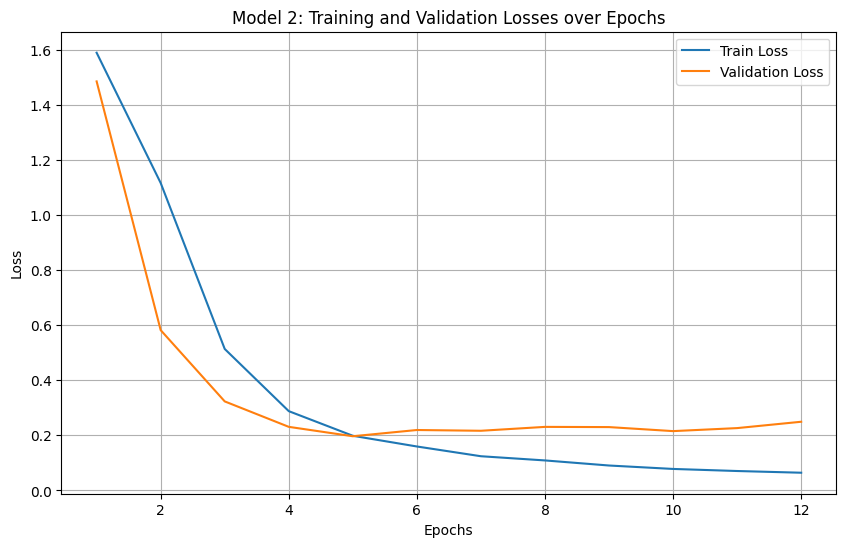

Accuracy plot for Configuration 2 saved as 'accuracy_plot_GRU_config_2.png'


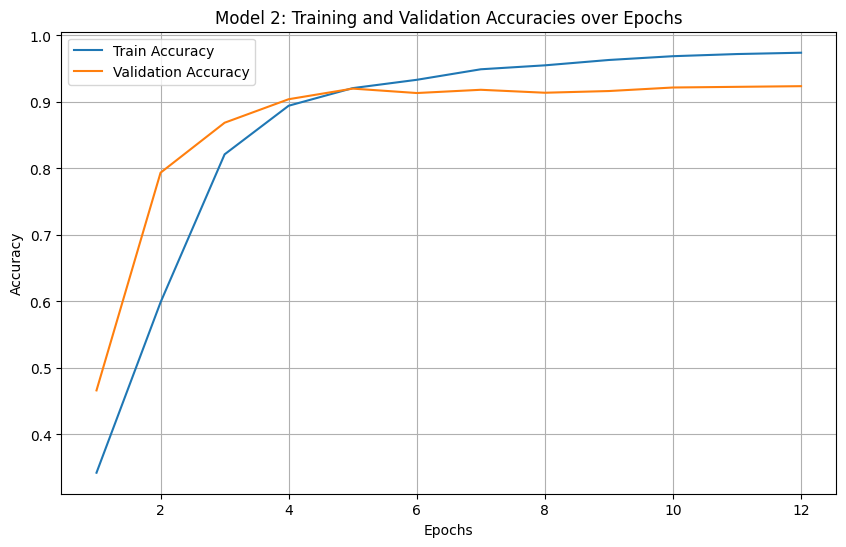

Confusion matrix for Configuration 2 saved as 'confusion_matrix_GRU_config_2.png'


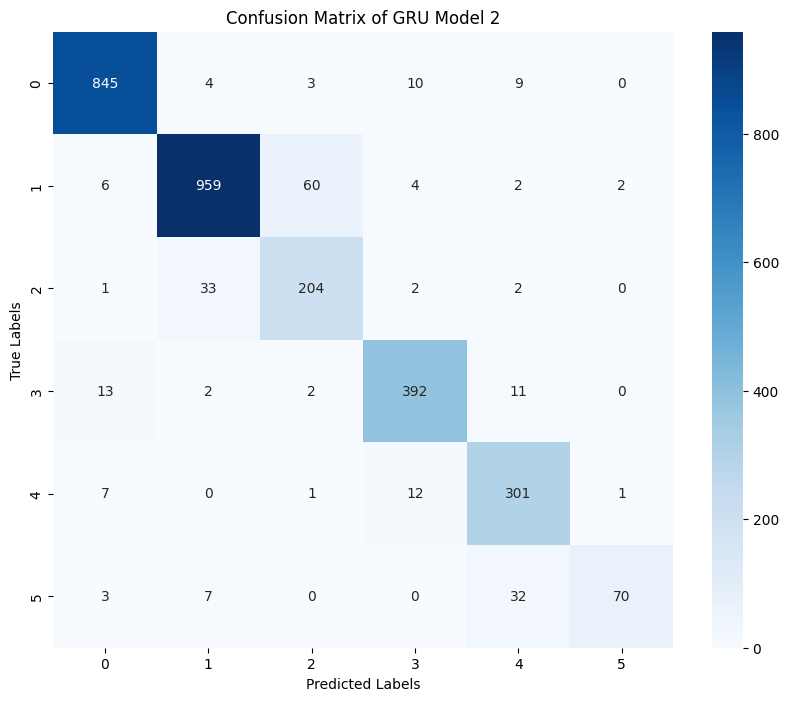


Configuration 3: {'EMBEDDING_DIM': 250, 'HIDDEN_DIM': 500, 'DROPOUT': 0.5, 'N_LAYERS': 4}
Epoch: 01
	Train Loss: 1.658 | Train Acc: 31.71%
	 Val. Loss: 1.597 |  Val. Acc: 30.77%
Epoch: 02
	Train Loss: 1.543 | Train Acc: 40.62%
	 Val. Loss: 1.293 |  Val. Acc: 55.37%
Epoch: 03
	Train Loss: 1.184 | Train Acc: 56.71%
	 Val. Loss: 0.756 |  Val. Acc: 69.58%
Epoch: 04
	Train Loss: 0.876 | Train Acc: 67.65%
	 Val. Loss: 0.585 |  Val. Acc: 80.09%
Epoch: 05
	Train Loss: 0.668 | Train Acc: 76.03%
	 Val. Loss: 0.506 |  Val. Acc: 78.16%
Epoch: 06
	Train Loss: 0.495 | Train Acc: 82.69%
	 Val. Loss: 0.332 |  Val. Acc: 88.77%
Epoch: 07
	Train Loss: 0.385 | Train Acc: 86.53%
	 Val. Loss: 0.276 |  Val. Acc: 91.19%
Epoch: 08
	Train Loss: 0.321 | Train Acc: 88.57%
	 Val. Loss: 0.198 |  Val. Acc: 92.23%
Epoch: 09
	Train Loss: 0.274 | Train Acc: 90.22%
	 Val. Loss: 0.189 |  Val. Acc: 91.91%
Epoch: 10
	Train Loss: 0.239 | Train Acc: 90.78%
	 Val. Loss: 0.190 |  Val. Acc: 91.38%
Epoch: 11
	Train Loss: 0.206 

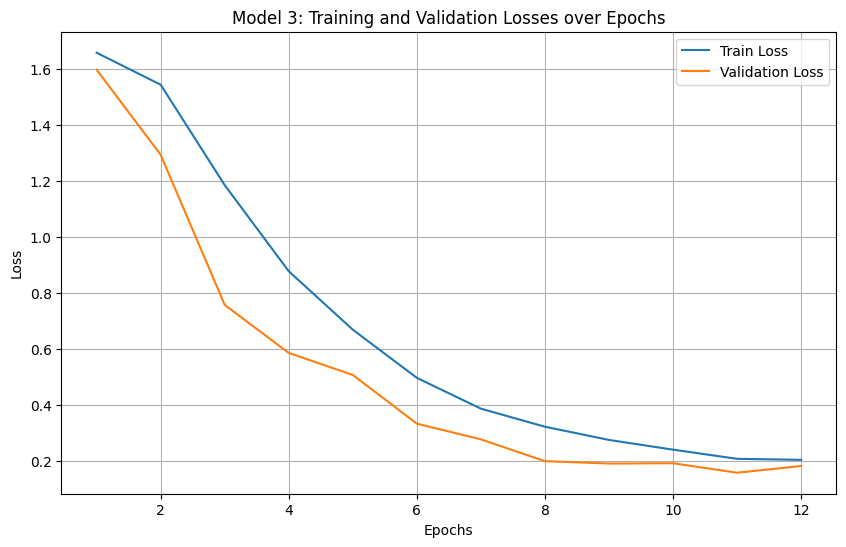

Accuracy plot for Configuration 3 saved as 'accuracy_plot_GRU_config_3.png'


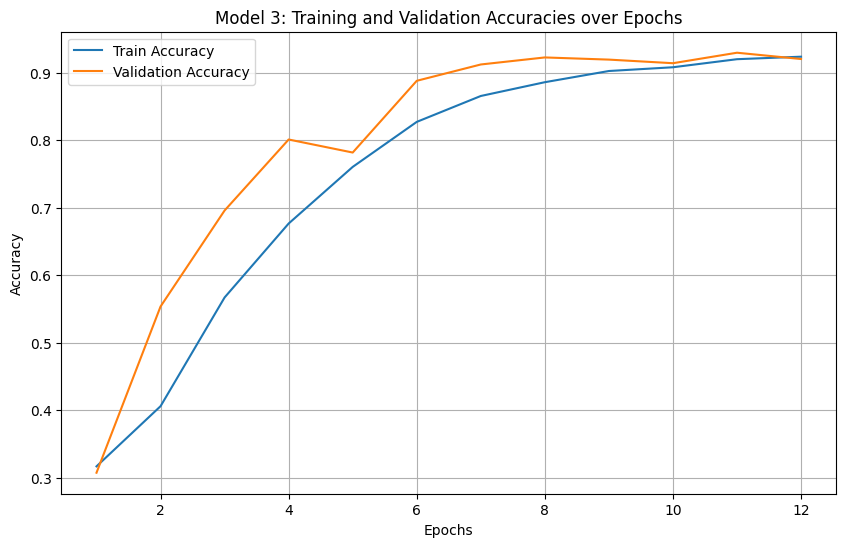

Confusion matrix for Configuration 3 saved as 'confusion_matrix_GRU_config_3.png'


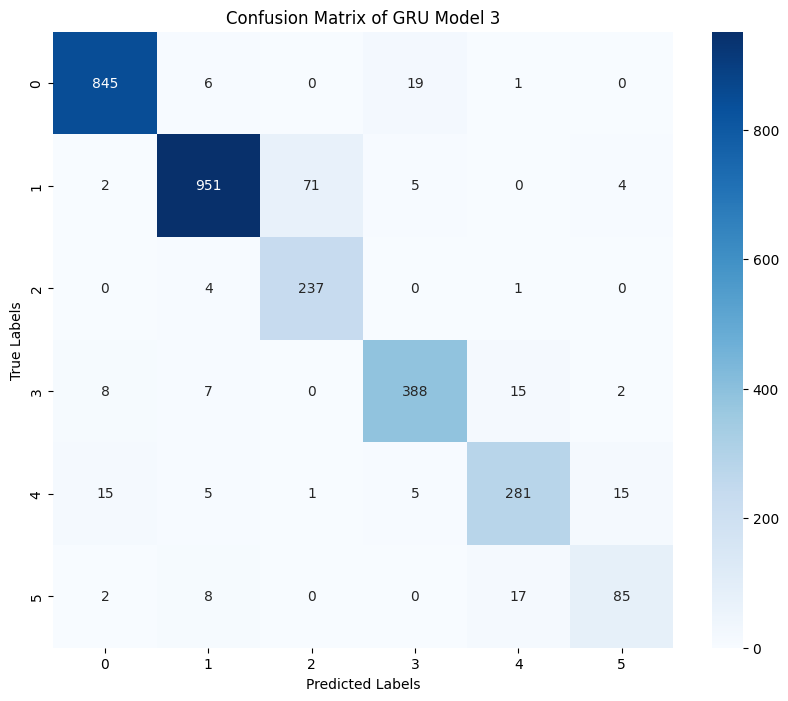

In [ ]:
configurations = [
    {'EMBEDDING_DIM': 128, 'HIDDEN_DIM': 256, 'DROPOUT': 0.3, 'N_LAYERS': 2},
    {'EMBEDDING_DIM': 150, 'HIDDEN_DIM': 300, 'DROPOUT': 0.25, 'N_LAYERS': 2},
    {'EMBEDDING_DIM': 250, 'HIDDEN_DIM': 500, 'DROPOUT': 0.5, 'N_LAYERS': 4}
]

results = []

for i, config in enumerate(configurations):
    print(f"\nConfiguration {i+1}: {config}")

    GRU_model = GRUModel(VOCAB_SIZE, config['EMBEDDING_DIM'], config['HIDDEN_DIM'], OUTPUT_DIM, config['N_LAYERS'], config['DROPOUT'])
    GRU_model = GRU_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(GRU_model.parameters())

    N_EPOCHS = 12
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train(GRU_model, train_loader, optimizer, criterion)
        val_loss, val_acc, _, _ = evaluate(GRU_model, val_loader, criterion)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    test_loss, test_acc, test_predictions, test_true_labels = evaluate(GRU_model, test_loader, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    classification_report_test = classification_report(test_true_labels, test_predictions, output_dict=True)
    print("Classification Report for GRU Model:\n")
    print(classification_report(test_true_labels, test_predictions))

    precision = classification_report_test['weighted avg']['precision']
    recall = classification_report_test['weighted avg']['recall']
    f1_score = classification_report_test['weighted avg']['f1-score']

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    results.append({
        'config': config,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'test_predictions': test_predictions,
        'test_true_labels': test_true_labels
    })
    #plotting loss over epoch and aacuracies over epochs
    # Plotting the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, N_EPOCHS + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Model {i+1}: Training and Validation Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_GRU_config_{i+1}.png')
    print(f"Loss plot for Configuration {i+1} saved as 'loss_plot_GRU_config_{i+1}.png'")
    plt.show()

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, N_EPOCHS + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, N_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model {i+1}: Training and Validation Accuracies over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_plot_GRU_config_{i+1}.png')
    print(f"Accuracy plot for Configuration {i+1} saved as 'accuracy_plot_GRU_config_{i+1}.png'")
    plt.show()

    # Confusion matrix
    conf_mat = confusion_matrix(test_true_labels, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of GRU Model {i+1}')
    plt.savefig(f'confusion_matrix_GRU_config_{i+1}.png')
    print(f"Confusion matrix for Configuration {i+1} saved as 'confusion_matrix_GRU_config_{i+1}.png'")
    plt.show()


Implementing BiLSTM Model

Using device: cuda
Epoch: 01
	Train Loss of BiLSTM model: 1.529 | Train Accuracy of BiLSTM model: 38.83%
	 Val. Loss of BiLSTM model: 1.253 |  Validation Accuracy of BiLSTM model: 54.13%
Epoch: 02
	Train Loss of BiLSTM model: 1.082 | Train Accuracy of BiLSTM model: 61.10%
	 Val. Loss of BiLSTM model: 0.566 |  Validation Accuracy of BiLSTM model: 81.54%
Epoch: 03
	Train Loss of BiLSTM model: 0.613 | Train Accuracy of BiLSTM model: 78.45%
	 Val. Loss of BiLSTM model: 0.284 |  Validation Accuracy of BiLSTM model: 90.25%
Epoch: 04
	Train Loss of BiLSTM model: 0.371 | Train Accuracy of BiLSTM model: 87.01%
	 Val. Loss of BiLSTM model: 0.227 |  Validation Accuracy of BiLSTM model: 91.51%
Epoch: 05
	Train Loss of BiLSTM model: 0.272 | Train Accuracy of BiLSTM model: 89.78%
	 Val. Loss of BiLSTM model: 0.156 |  Validation Accuracy of BiLSTM model: 92.54%
Epoch: 06
	Train Loss of BiLSTM model: 0.218 | Train Accuracy of BiLSTM model: 91.33%
	 Val. Loss of BiLSTM model: 0.174 |  Validation Accura

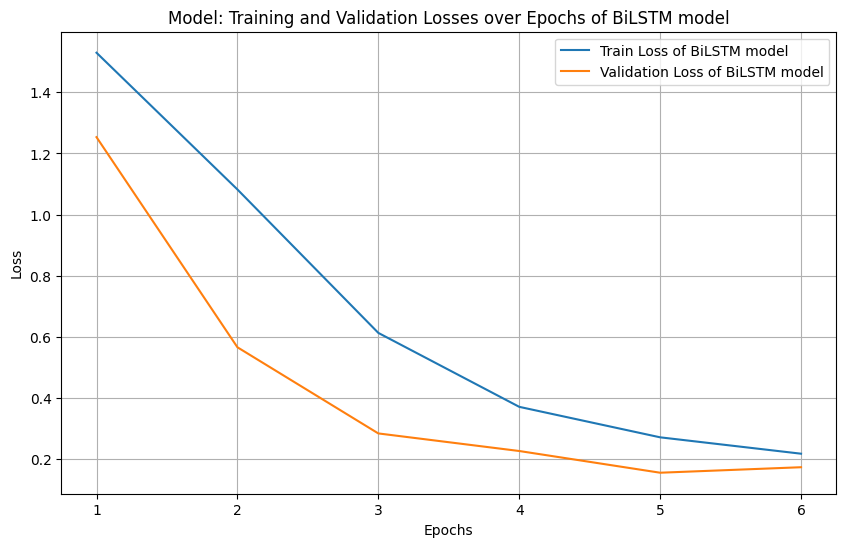

Accuracy plot saved as 'accuracy_plot_bilstm.png'


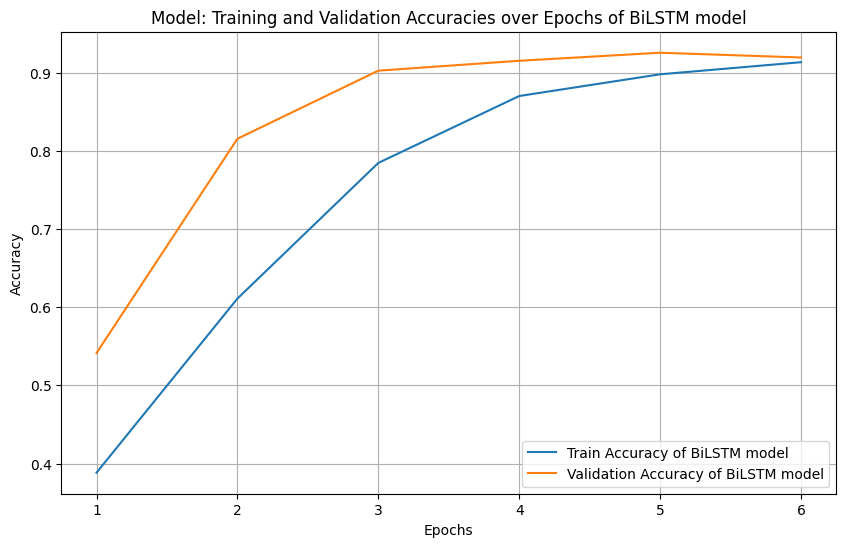

Confusion matrix plot saved as 'confusion_matrix_bilstm.png'


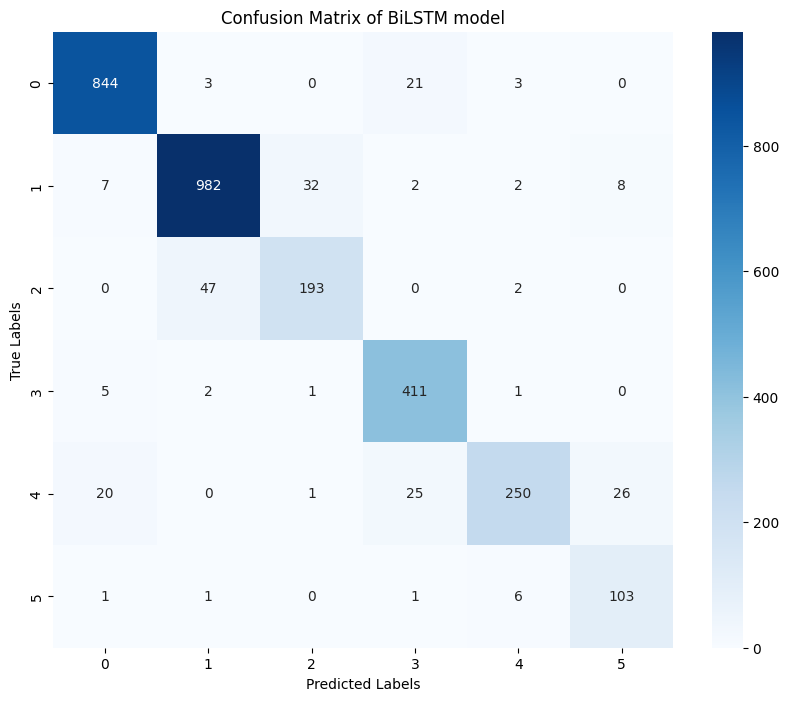

In [ ]:


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 200
HIDDEN_DIM = 512
OUTPUT_DIM = 6
N_LAYERS = 4
DROPOUT = 0.5

BiLSTM_model = BiLSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
BiLSTM_model = BiLSTM_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(BiLSTM_model.parameters())

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = ((predictions.argmax(1) == labels).float().mean())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            outputs = model(text)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            acc = ((outputs.argmax(1) == labels).float().mean())
            epoch_acc += acc.item()
            predictions.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, true_labels

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

N_EPOCHS = 6
train_accuracies_bilstm = []
val_accuracies_bilstm = []
train_losses_bilstm = []
val_losses_bilstm = []

for epoch in range(N_EPOCHS):
    train_loss_bilstm, train_acc_bilstm = train(BiLSTM_model, train_loader, optimizer, criterion)
    val_loss_bilstm, val_acc_bilstm, _, _ = evaluate(BiLSTM_model, val_loader, criterion)

    train_accuracies_bilstm.append(train_acc_bilstm)
    val_accuracies_bilstm.append(val_acc_bilstm)
    train_losses_bilstm.append(train_loss_bilstm)
    val_losses_bilstm.append(val_loss_bilstm)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss of BiLSTM model: {train_loss_bilstm:.3f} | Train Accuracy of BiLSTM model: {train_acc_bilstm*100:.2f}%')
    print(f'\t Val. Loss of BiLSTM model: {val_loss_bilstm:.3f} |  Validation Accuracy of BiLSTM model: {val_acc_bilstm*100:.2f}%')

test_loss_bilstm, test_acc_bilstm, test_predictions_bilstm, test_true_labels_bilstm = evaluate(BiLSTM_model, test_loader, criterion)
print(f'Test Loss of BiLSTM: {test_loss_bilstm:.3f} | Test Acc of BiLSTM: {test_acc_bilstm*100:.2f}%')

test_precision_bilstm = precision_score(test_true_labels_bilstm, test_predictions_bilstm, average='weighted')
test_recall_bilstm = recall_score(test_true_labels_bilstm, test_predictions_bilstm, average='weighted')
print(f'Test Precision of BiLSTM: {test_precision_bilstm:.3f}')
print(f'Test Recall of BiLSTM: {test_recall_bilstm:.3f}')


# Plotting the losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses_bilstm, label='Train Loss of BiLSTM model')
plt.plot(range(1, N_EPOCHS + 1), val_losses_bilstm, label='Validation Loss of BiLSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model: Training and Validation Losses over Epochs of BiLSTM model')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_bilstm.png')
print("Loss plot saved as 'loss_plot_bilstm.png'")
plt.show()

# Plotting the accuracies over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_accuracies_bilstm, label='Train Accuracy of BiLSTM model')
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_bilstm, label='Validation Accuracy of BiLSTM model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model: Training and Validation Accuracies over Epochs of BiLSTM model')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot_bilstm.png')
print("Accuracy plot saved as 'accuracy_plot_bilstm.png'")
plt.show()

# Confusion matrix
conf_mat_bilstm = confusion_matrix(test_true_labels_bilstm, test_predictions_bilstm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_bilstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of BiLSTM model')
plt.savefig('confusion_matrix_bilstm.png')
print("Confusion matrix plot saved as 'confusion_matrix_bilstm.png'")
plt.show()


predicting with sample text

In [ ]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def predict_sentiment(texts):
    BiLSTM_model.eval()
    predictions = []

    for text in texts:
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, padding='post', maxlen=50)
        tensor_sequence = torch.LongTensor(padded_sequence).to(device)

        with torch.no_grad():
            output = BiLSTM_model(tensor_sequence)
            predicted_class = output.argmax(axis=1).item()

        predictions.append(class_labels[predicted_class])
    for i, prediction in enumerate(predictions):
        print(f'Text {i+1}: Predicted sentiment is {prediction}')

predict_sentiment(['I am feeling grouchy', 'This movie made me so happy'])


Text 1: Predicted sentiment is anger
Text 2: Predicted sentiment is joy


Implementing BILSTM model and experimenting with different parameter settings

Using device: cuda

Training BiLSTM model with hyperparameters set 1: {'EMBEDDING_DIM': 100, 'HIDDEN_DIM': 256, 'N_LAYERS': 2, 'DROPOUT': 0.3}

Epoch: 01
	Train Loss: 1.427 | Train Accuracy: 44.34%
	 Val. Loss: 0.942 |  Validation Accuracy: 65.47%
Epoch: 02
	Train Loss: 0.738 | Train Accuracy: 73.83%
	 Val. Loss: 0.435 |  Validation Accuracy: 84.62%
Epoch: 03
	Train Loss: 0.385 | Train Accuracy: 86.11%
	 Val. Loss: 0.267 |  Validation Accuracy: 88.86%
Epoch: 04
	Train Loss: 0.250 | Train Accuracy: 90.37%
	 Val. Loss: 0.201 |  Validation Accuracy: 90.66%
Epoch: 05
	Train Loss: 0.193 | Train Accuracy: 92.29%
	 Val. Loss: 0.193 |  Validation Accuracy: 91.43%
Epoch: 06
	Train Loss: 0.155 | Train Accuracy: 93.38%
	 Val. Loss: 0.178 |  Validation Accuracy: 91.63%
Test Loss: 0.167 | Test Acc: 92.32%
Test Precision: 0.923
Test Recall: 0.923
Loss plot saved as 'loss_plot_BiLSTM_model_1.png'


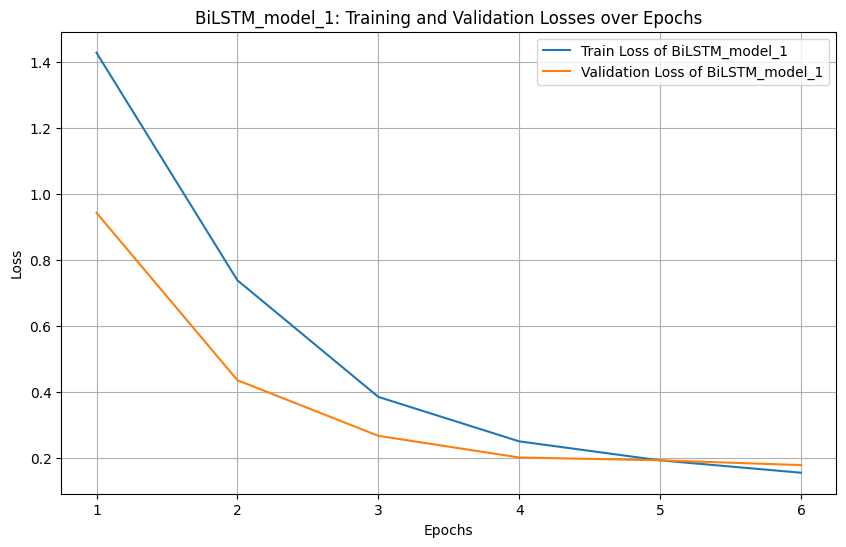

Accuracy plot saved as 'accuracy_plot_BiLSTM_model_1.png'


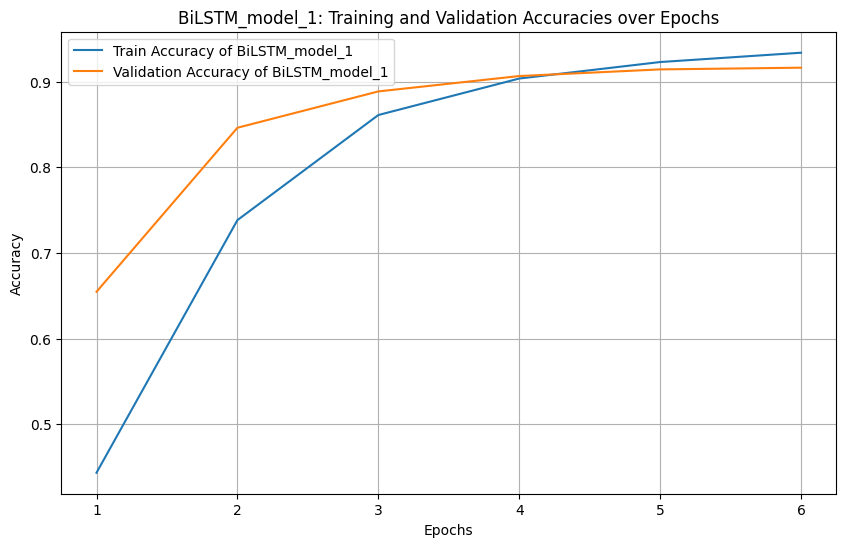

Confusion matrix plot saved as 'confusion_matrix_BiLSTM_model_1.png'


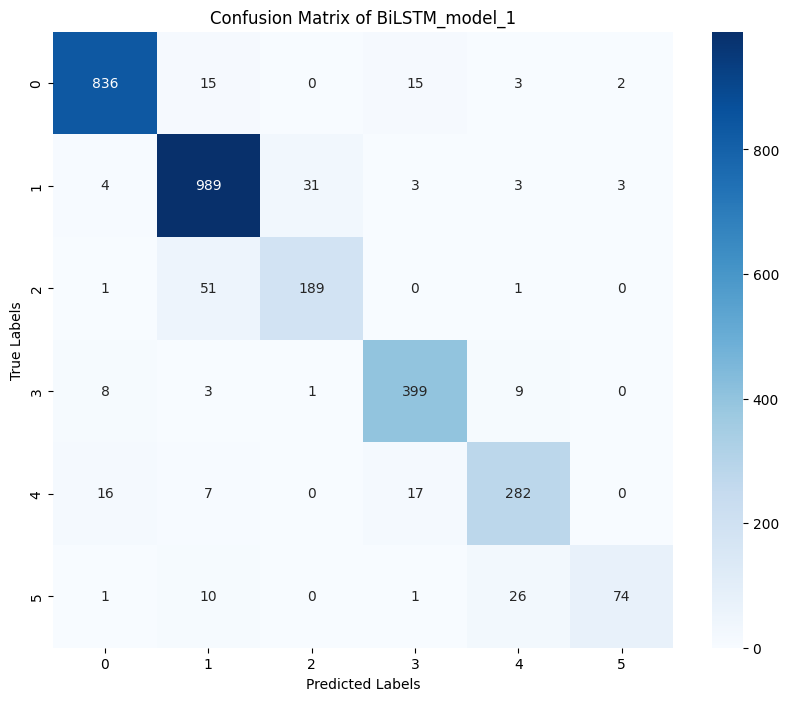


Training BiLSTM model with hyperparameters set 2: {'EMBEDDING_DIM': 300, 'HIDDEN_DIM': 512, 'N_LAYERS': 3, 'DROPOUT': 0.4}

Epoch: 01
	Train Loss: 1.248 | Train Accuracy: 51.99%
	 Val. Loss: 0.496 |  Validation Accuracy: 84.43%
Epoch: 02
	Train Loss: 0.438 | Train Accuracy: 84.72%
	 Val. Loss: 0.219 |  Validation Accuracy: 91.51%
Epoch: 03
	Train Loss: 0.221 | Train Accuracy: 91.14%
	 Val. Loss: 0.164 |  Validation Accuracy: 92.40%
Epoch: 04
	Train Loss: 0.165 | Train Accuracy: 92.92%
	 Val. Loss: 0.152 |  Validation Accuracy: 92.38%
Epoch: 05
	Train Loss: 0.141 | Train Accuracy: 93.66%
	 Val. Loss: 0.147 |  Validation Accuracy: 93.23%
Epoch: 06
	Train Loss: 0.119 | Train Accuracy: 94.42%
	 Val. Loss: 0.160 |  Validation Accuracy: 92.58%
Test Loss: 0.136 | Test Acc: 93.18%
Test Precision: 0.933
Test Recall: 0.932
Loss plot saved as 'loss_plot_BiLSTM_model_2.png'


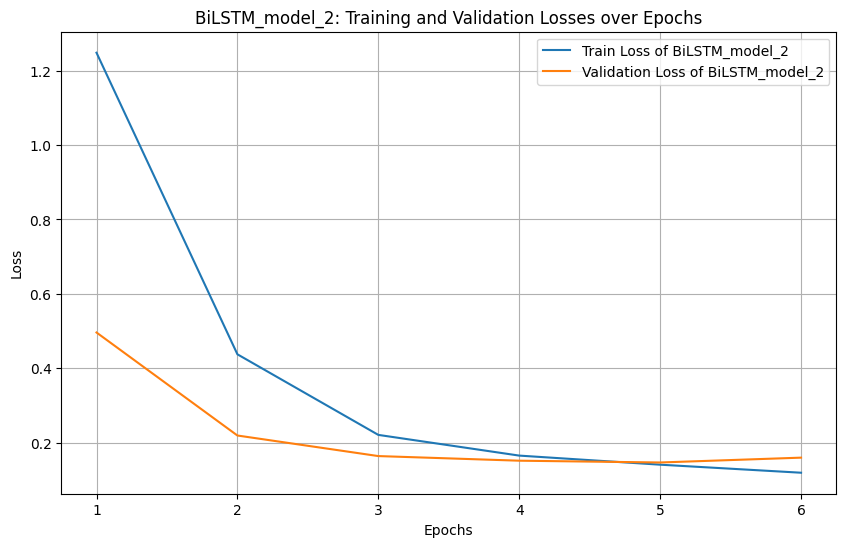

Accuracy plot saved as 'accuracy_plot_BiLSTM_model_2.png'


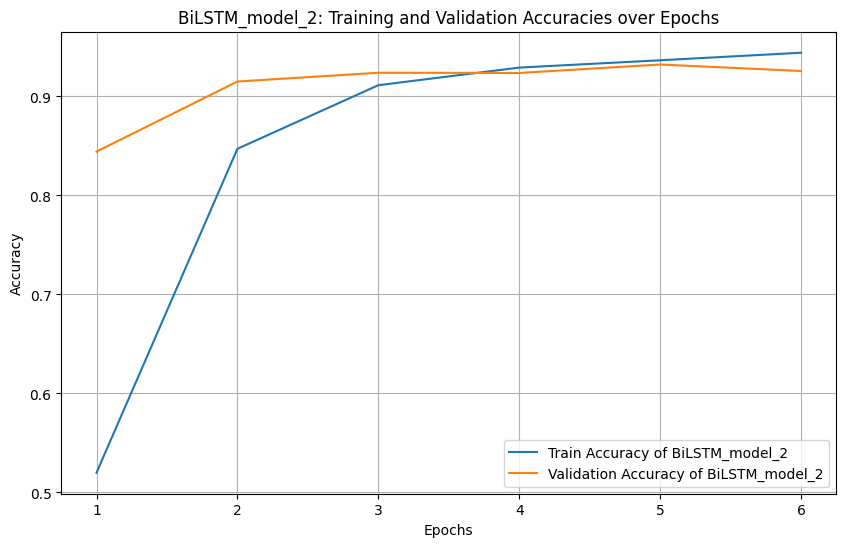

Confusion matrix plot saved as 'confusion_matrix_BiLSTM_model_2.png'


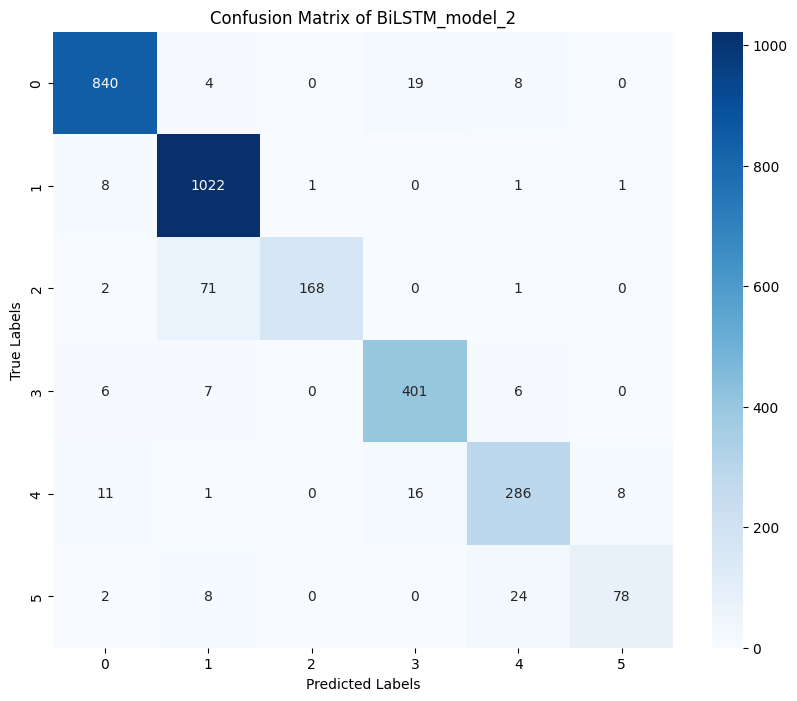


Training BiLSTM model with hyperparameters set 3: {'EMBEDDING_DIM': 200, 'HIDDEN_DIM': 128, 'N_LAYERS': 1, 'DROPOUT': 0.2}



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 01
	Train Loss: 1.344 | Train Accuracy: 48.13%
	 Val. Loss: 0.782 |  Validation Accuracy: 73.94%
Epoch: 02
	Train Loss: 0.551 | Train Accuracy: 81.65%
	 Val. Loss: 0.348 |  Validation Accuracy: 87.39%
Epoch: 03
	Train Loss: 0.278 | Train Accuracy: 90.23%
	 Val. Loss: 0.298 |  Validation Accuracy: 89.34%
Epoch: 04
	Train Loss: 0.185 | Train Accuracy: 93.43%
	 Val. Loss: 0.267 |  Validation Accuracy: 89.99%
Epoch: 05
	Train Loss: 0.133 | Train Accuracy: 95.11%
	 Val. Loss: 0.260 |  Validation Accuracy: 90.30%
Epoch: 06
	Train Loss: 0.106 | Train Accuracy: 96.05%
	 Val. Loss: 0.272 |  Validation Accuracy: 90.33%
Test Loss: 0.252 | Test Acc: 90.89%
Test Precision: 0.911
Test Recall: 0.909
Loss plot saved as 'loss_plot_BiLSTM_model_3.png'


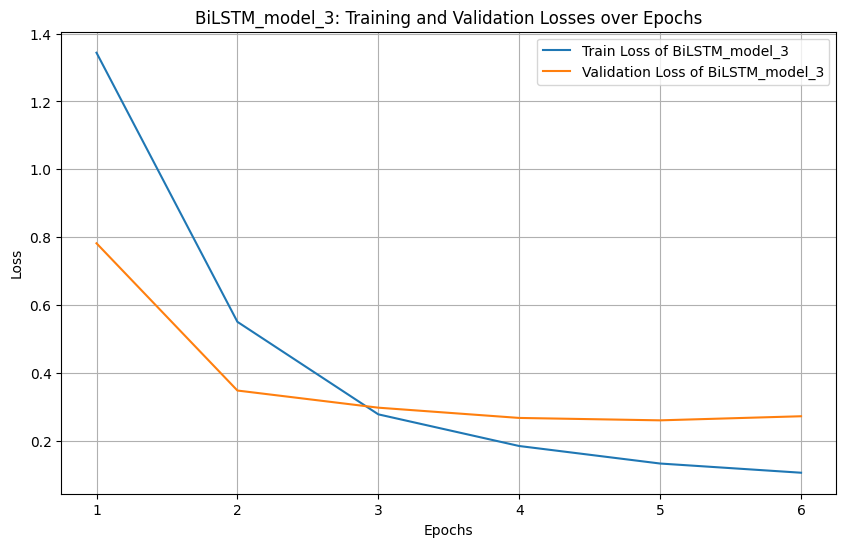

Accuracy plot saved as 'accuracy_plot_BiLSTM_model_3.png'


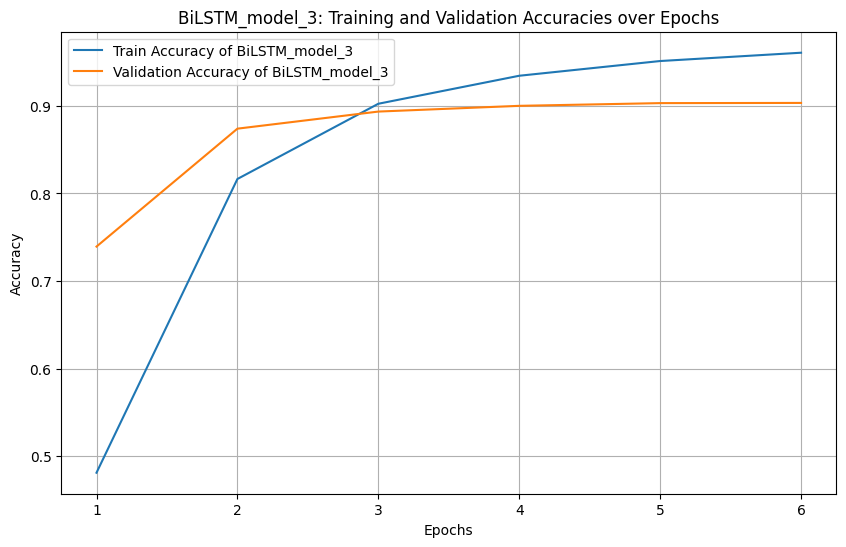

Confusion matrix plot saved as 'confusion_matrix_BiLSTM_model_3.png'


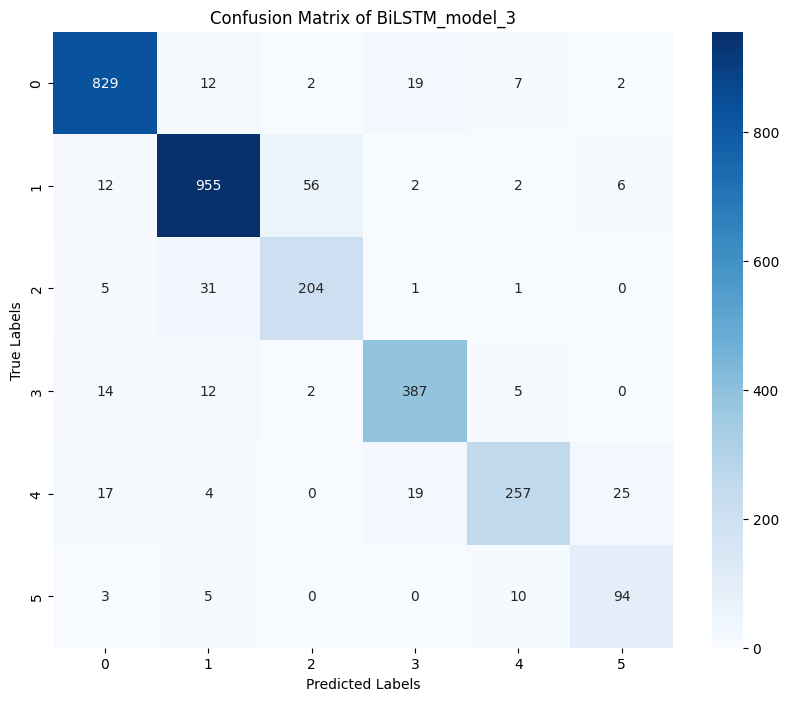

In [ ]:


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = ((predictions.argmax(1) == labels).float().mean())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            outputs = model(text)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            acc = ((outputs.argmax(1) == labels).float().mean())
            epoch_acc += acc.item()
            predictions.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, true_labels

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, N_EPOCHS + 1), train_losses, label=f'Train Loss of {name}')
    plt.plot(range(1, N_EPOCHS + 1), val_losses, label=f'Validation Loss of {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{name}: Training and Validation Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_{name}.png')
    print(f"Loss plot saved as 'loss_plot_{name}.png'")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, N_EPOCHS + 1), train_accuracies, label=f'Train Accuracy of {name}')
    plt.plot(range(1, N_EPOCHS + 1), val_accuracies, label=f'Validation Accuracy of {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{name}: Training and Validation Accuracies over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_plot_{name}.png')
    print(f"Accuracy plot saved as 'accuracy_plot_{name}.png'")
    plt.show()

def plot_confusion_matrix(true_labels, predictions, name):
    conf_mat = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {name}')
    plt.savefig(f'confusion_matrix_{name}.png')
    print(f"Confusion matrix plot saved as 'confusion_matrix_{name}.png'")
    plt.show()

hyperparams = [
    {'EMBEDDING_DIM': 100, 'HIDDEN_DIM': 256, 'N_LAYERS': 2, 'DROPOUT': 0.3},
    {'EMBEDDING_DIM': 300, 'HIDDEN_DIM': 512, 'N_LAYERS': 3, 'DROPOUT': 0.4},
    {'EMBEDDING_DIM': 200, 'HIDDEN_DIM': 128, 'N_LAYERS': 1, 'DROPOUT': 0.2}
]

for i, params in enumerate(hyperparams):
    print(f"\nTraining BiLSTM model with hyperparameters set {i+1}: {params}\n")

    BiLSTM_model = BiLSTMModel(VOCAB_SIZE, params['EMBEDDING_DIM'], params['HIDDEN_DIM'], OUTPUT_DIM, params['N_LAYERS'], params['DROPOUT'])
    BiLSTM_model = BiLSTM_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(BiLSTM_model.parameters())

    N_EPOCHS = 6
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train(BiLSTM_model, train_loader, optimizer, criterion)
        val_loss, val_acc, _, _ = evaluate(BiLSTM_model, val_loader, criterion)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {val_loss:.3f} |  Validation Accuracy: {val_acc*100:.2f}%')

    test_loss, test_acc, test_predictions, test_true_labels = evaluate(BiLSTM_model, test_loader, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    test_precision = precision_score(test_true_labels, test_predictions, average='weighted')
    test_recall = recall_score(test_true_labels, test_predictions, average='weighted')
    print(f'Test Precision: {test_precision:.3f}')
    print(f'Test Recall: {test_recall:.3f}')

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, f'BiLSTM_model_{i+1}')
    plot_confusion_matrix(test_true_labels, test_predictions, f'BiLSTM_model_{i+1}')


Implementing stacked LSTM model

Using device: cuda
Epoch: 01
	Train Loss: 1.590 | Train Acc: 33.07%
	 Val. Loss: 1.585 |  Val. Acc: 32.26%
Epoch: 02
	Train Loss: 1.583 | Train Acc: 33.62%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Epoch: 03
	Train Loss: 1.582 | Train Acc: 33.47%
	 Val. Loss: 1.580 |  Val. Acc: 32.26%
Epoch: 04
	Train Loss: 1.582 | Train Acc: 33.59%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Epoch: 05
	Train Loss: 1.580 | Train Acc: 33.45%
	 Val. Loss: 1.586 |  Val. Acc: 32.26%
Epoch: 06
	Train Loss: 1.580 | Train Acc: 33.67%
	 Val. Loss: 1.576 |  Val. Acc: 32.26%
Test Loss: 1.568 | Test Acc: 34.42%
Test Precision: 0.119
Test Recall: 0.344
Loss plot saved as 'loss_plot_stackedlstm.png'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


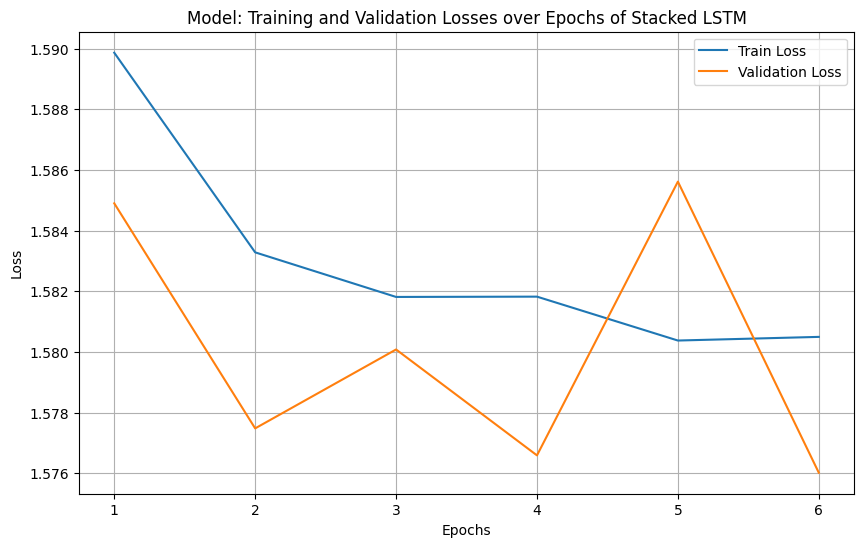

Accuracy plot saved as 'accuracy_plot_stackedlstm.png'


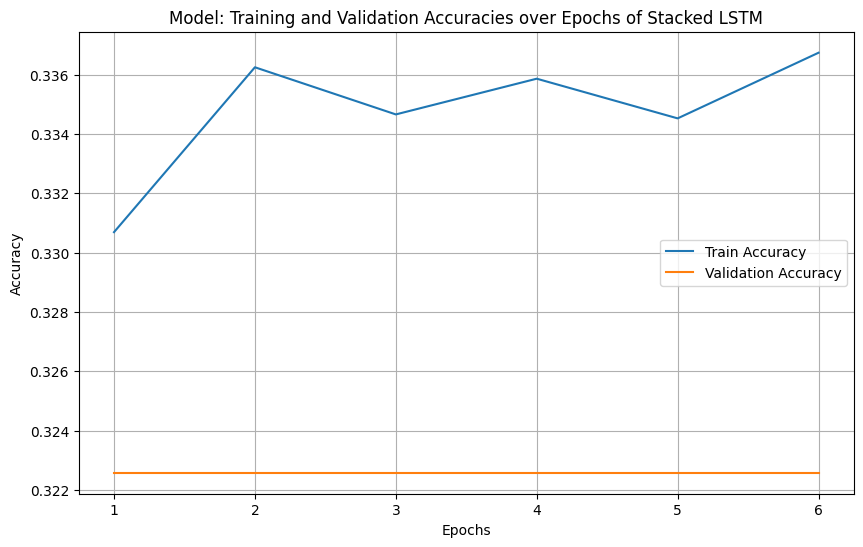

Confusion matrix plot saved as 'confusion_matrix_stackedlstm.png'


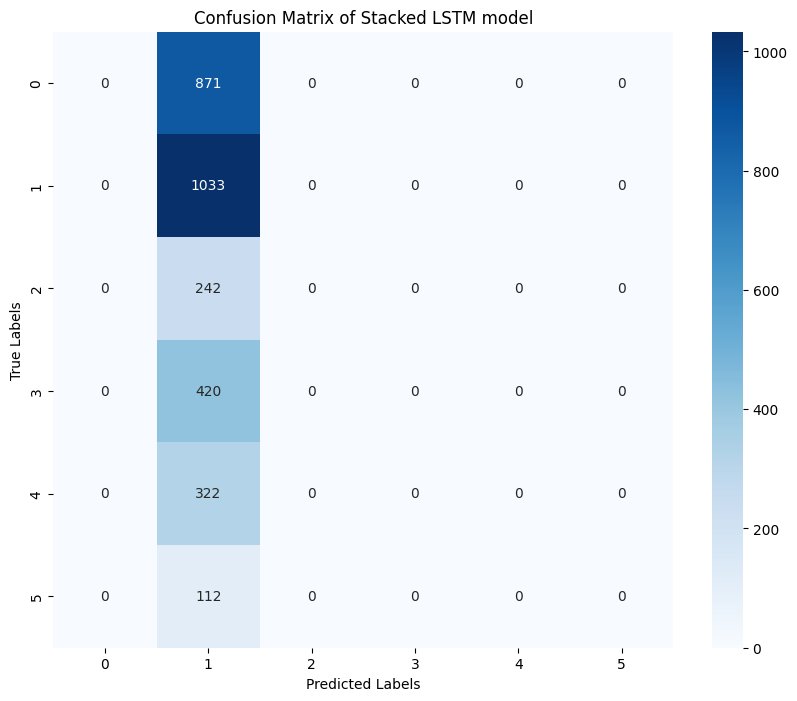

In [ ]:


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class StackedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 200
HIDDEN_DIM = 512
OUTPUT_DIM = 6
N_LAYERS = 4
DROPOUT = 0.5

stacked_lstm_model = StackedLSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
stacked_lstm_model = stacked_lstm_model.to(device)

#  loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(stacked_lstm_model.parameters())

# Training phase
def train(model, iterator, optimizer, criterion):
    stacked_lstm_model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()

        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = stacked_lstm_model(text)

        loss = criterion(predictions, labels)
        acc = ((predictions.argmax(1) == labels).float().mean())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    stacked_lstm_model.eval()
    epoch_loss = 0
    epoch_acc = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            outputs = stacked_lstm_model(text)

            loss = criterion(outputs, labels)
            acc = ((outputs.argmax(1) == labels).float().mean())

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            predictions.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, true_labels

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

N_EPOCHS = 6
train_accuracies_stackedlstm = []
val_accuracies_stackedlstm = []
train_losses_stackedlstm = []
val_losses_stackedlstm = []

for epoch in range(N_EPOCHS):
    train_loss_stackedlstm, train_acc_stackedlstm = train(stacked_lstm_model, train_loader, optimizer, criterion)
    val_loss_stackedlstm, val_acc_stackedlstm, _, _ = evaluate(stacked_lstm_model, val_loader, criterion)

    train_accuracies_stackedlstm.append(train_acc_stackedlstm)
    val_accuracies_stackedlstm.append(val_acc_stackedlstm)
    train_losses_stackedlstm.append(train_loss_stackedlstm)
    val_losses_stackedlstm.append(val_loss_stackedlstm)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss_stackedlstm:.3f} | Train Acc: {train_acc_stackedlstm*100:.2f}%')
    print(f'\t Val. Loss: {val_loss_stackedlstm:.3f} |  Val. Acc: {val_acc_stackedlstm*100:.2f}%')

test_loss_stackedlstm, test_acc_stackedlstm, test_predictions_stackedlstm, test_true_labels_stackedlstm = evaluate(stacked_lstm_model, test_loader, criterion)
print(f'Test Loss: {test_loss_stackedlstm:.3f} | Test Acc: {test_acc_stackedlstm*100:.2f}%')

#  precision, recall, and f1 score
test_precision_stackedlstm = precision_score(test_true_labels_stackedlstm, test_predictions_stackedlstm, average='weighted')
test_recall_stackedlstm = recall_score(test_true_labels_stackedlstm, test_predictions_stackedlstm, average='weighted')
print(f'Test Precision: {test_precision_stackedlstm:.3f}')
print(f'Test Recall: {test_recall_stackedlstm:.3f}')

# Plotting the losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses_stackedlstm, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), val_losses_stackedlstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model: Training and Validation Losses over Epochs of Stacked LSTM')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_stackedlstm.png')
print("Loss plot saved as 'loss_plot_stackedlstm.png'")
plt.show()

# Plotting the accuracies over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_accuracies_stackedlstm, label='Train Accuracy')
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_stackedlstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model: Training and Validation Accuracies over Epochs of Stacked LSTM')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot_stackedlstm.png')
print("Accuracy plot saved as 'accuracy_plot_stackedlstm.png'")
plt.show()

# Confusion matrix
conf_mat_stackedlstm = confusion_matrix(test_true_labels_stackedlstm, test_predictions_stackedlstm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_stackedlstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Stacked LSTM model')
plt.savefig('confusion_matrix_stackedlstm.png')
print("Confusion matrix plot saved as 'confusion_matrix_stackedlstm.png'")
plt.show()


Predicting with sample text

In [ ]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def predict_sentiment(texts):
    stacked_lstm_model.eval()
    predictions = []

    for text in texts:
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, padding='post', maxlen=50)
        tensor_sequence = torch.LongTensor(padded_sequence).to(device)

        with torch.no_grad():
            output = stacked_lstm_model(tensor_sequence)
            predicted_class = output.argmax(axis=1).item()

        predictions.append(class_labels[predicted_class])

    for i, prediction in enumerate(predictions):
        print(f'Text {i+1}: Predicted sentiment is {prediction}')

predict_sentiment(['i feel angered and firey', 'This movie made me so happy'])


Experimenting with different parameters setting on StackedLstm model

Using device: cuda
Training with hyperparameters set 1: {'embedding_dim': 300, 'hidden_dim': 256, 'n_layers': 3, 'dropout': 0.3}
Epoch: 01
	Train Loss: 1.586 | Train Acc: 32.98%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Epoch: 02
	Train Loss: 1.580 | Train Acc: 33.75%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Epoch: 03
	Train Loss: 1.580 | Train Acc: 33.49%
	 Val. Loss: 1.579 |  Val. Acc: 32.26%
Epoch: 04
	Train Loss: 1.579 | Train Acc: 33.87%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Epoch: 05
	Train Loss: 1.579 | Train Acc: 33.83%
	 Val. Loss: 1.579 |  Val. Acc: 32.26%
Epoch: 06
	Train Loss: 1.578 | Train Acc: 33.77%
	 Val. Loss: 1.579 |  Val. Acc: 32.26%
Test Loss: 1.569 | Test Acc: 34.42%
Test Precision: 0.119
Test Recall: 0.344
Loss plot saved as 'loss_plot_stackedlstm_1.png'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


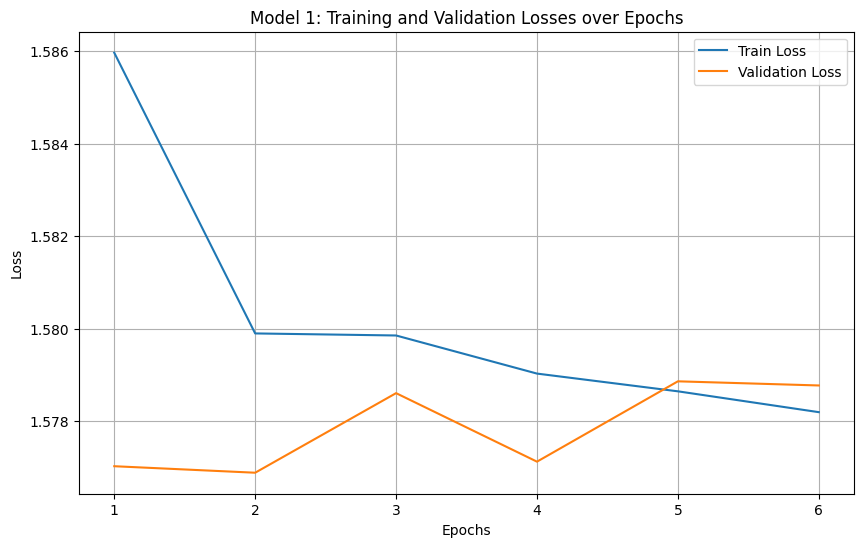

Accuracy plot saved as 'accuracy_plot_stackedlstm_1.png'


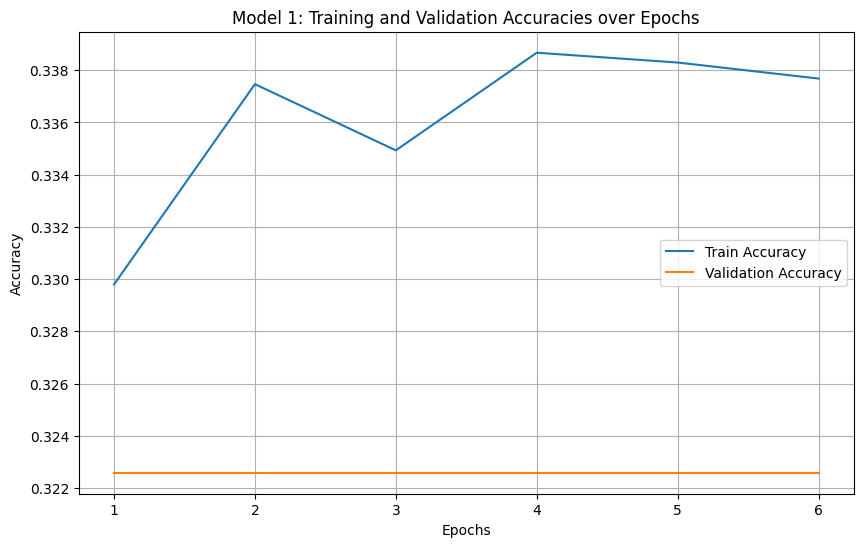

Confusion matrix plot saved as 'confusion_matrix_stackedlstm_1.png'


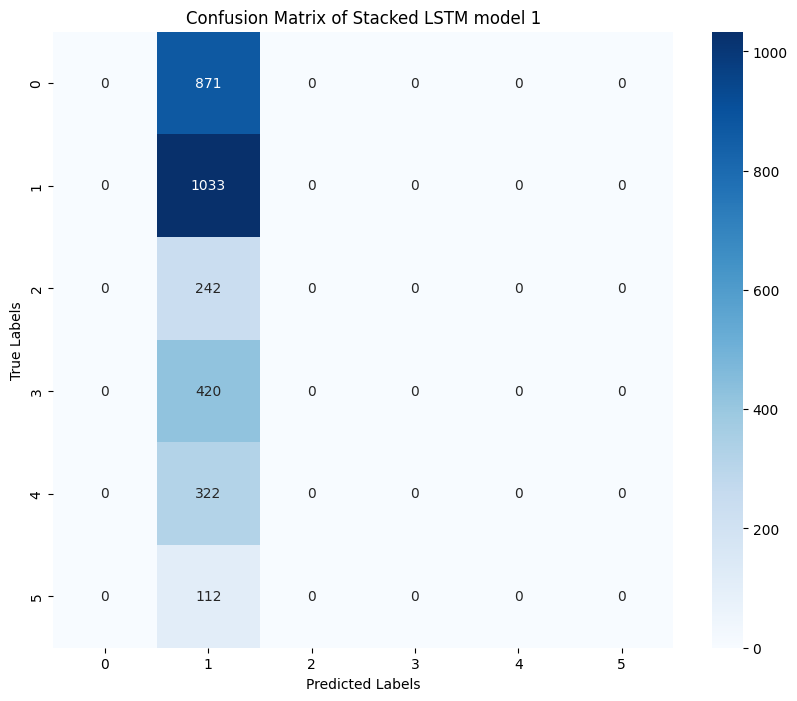

Training with hyperparameters set 2: {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.4}
Epoch: 01
	Train Loss: 1.588 | Train Acc: 33.05%
	 Val. Loss: 1.580 |  Val. Acc: 32.26%
Epoch: 02
	Train Loss: 1.581 | Train Acc: 33.44%
	 Val. Loss: 1.578 |  Val. Acc: 32.26%
Epoch: 03
	Train Loss: 1.581 | Train Acc: 33.71%
	 Val. Loss: 1.579 |  Val. Acc: 32.26%
Epoch: 04
	Train Loss: 1.580 | Train Acc: 33.95%
	 Val. Loss: 1.579 |  Val. Acc: 32.26%
Epoch: 05
	Train Loss: 1.579 | Train Acc: 34.06%
	 Val. Loss: 1.579 |  Val. Acc: 32.26%
Epoch: 06
	Train Loss: 1.579 | Train Acc: 33.88%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Test Loss: 1.568 | Test Acc: 34.42%
Test Precision: 0.119
Test Recall: 0.344
Loss plot saved as 'loss_plot_stackedlstm_2.png'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


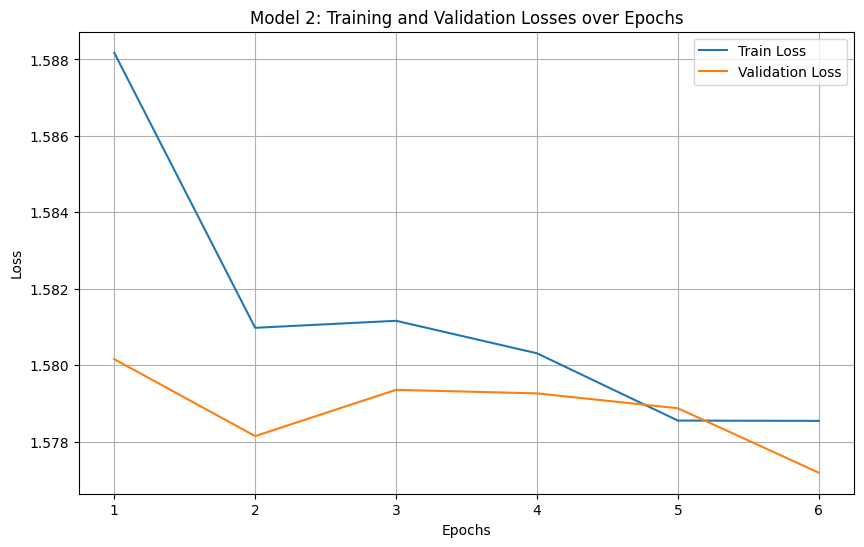

Accuracy plot saved as 'accuracy_plot_stackedlstm_2.png'


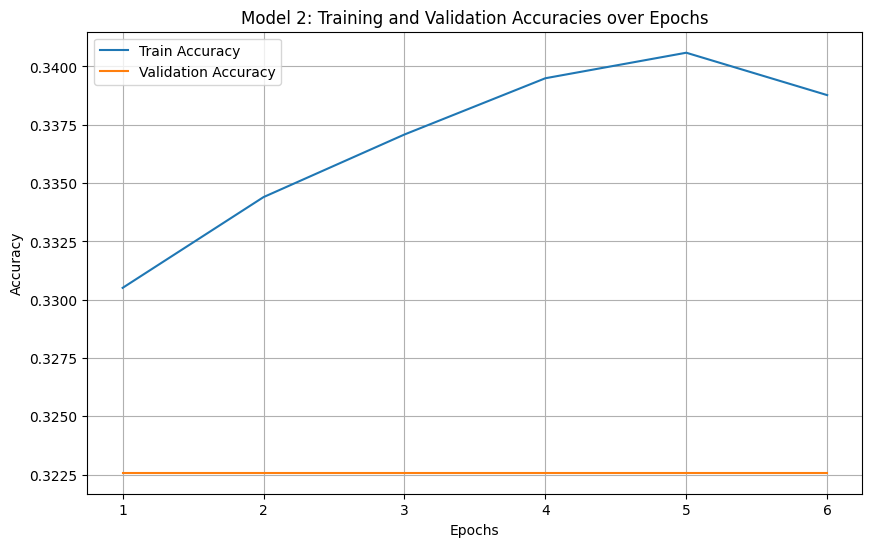

Confusion matrix plot saved as 'confusion_matrix_stackedlstm_2.png'


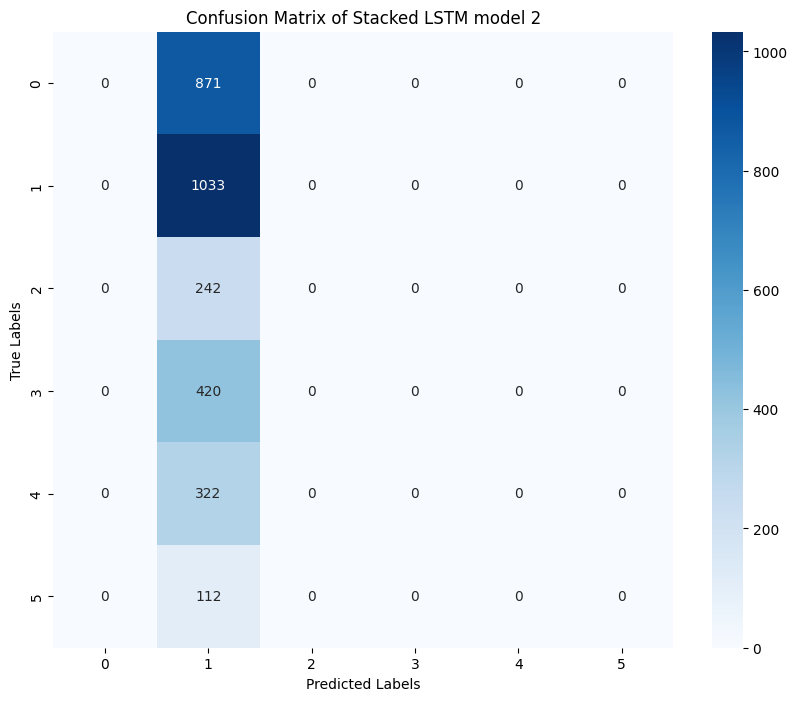

Training with hyperparameters set 3: {'embedding_dim': 200, 'hidden_dim': 256, 'n_layers': 1, 'dropout': 0.2}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 01
	Train Loss: 1.586 | Train Acc: 32.94%
	 Val. Loss: 1.575 |  Val. Acc: 30.77%
Epoch: 02
	Train Loss: 1.581 | Train Acc: 33.15%
	 Val. Loss: 1.575 |  Val. Acc: 32.26%
Epoch: 03
	Train Loss: 1.580 | Train Acc: 33.82%
	 Val. Loss: 1.575 |  Val. Acc: 32.26%
Epoch: 04
	Train Loss: 1.580 | Train Acc: 33.80%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Epoch: 05
	Train Loss: 1.579 | Train Acc: 33.92%
	 Val. Loss: 1.578 |  Val. Acc: 32.26%
Epoch: 06
	Train Loss: 1.578 | Train Acc: 33.96%
	 Val. Loss: 1.577 |  Val. Acc: 32.26%
Test Loss: 1.570 | Test Acc: 34.42%
Test Precision: 0.119
Test Recall: 0.344
Loss plot saved as 'loss_plot_stackedlstm_3.png'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


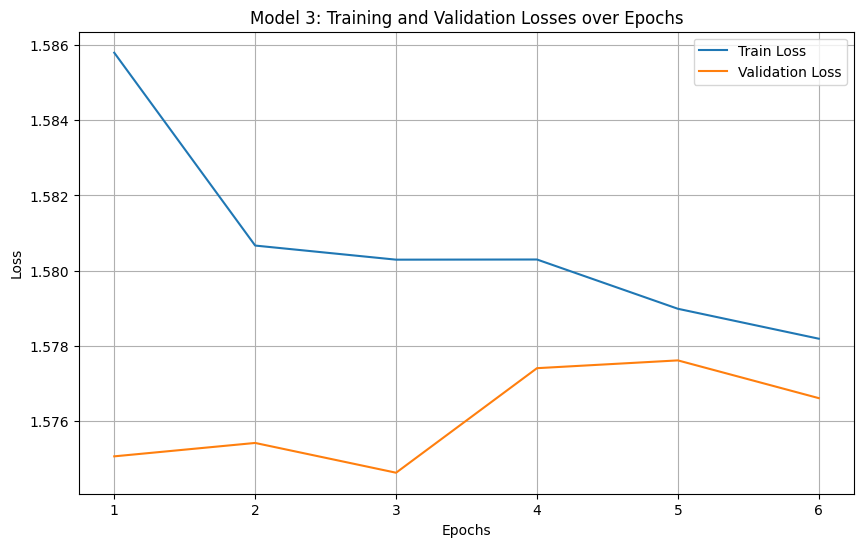

Accuracy plot saved as 'accuracy_plot_stackedlstm_3.png'


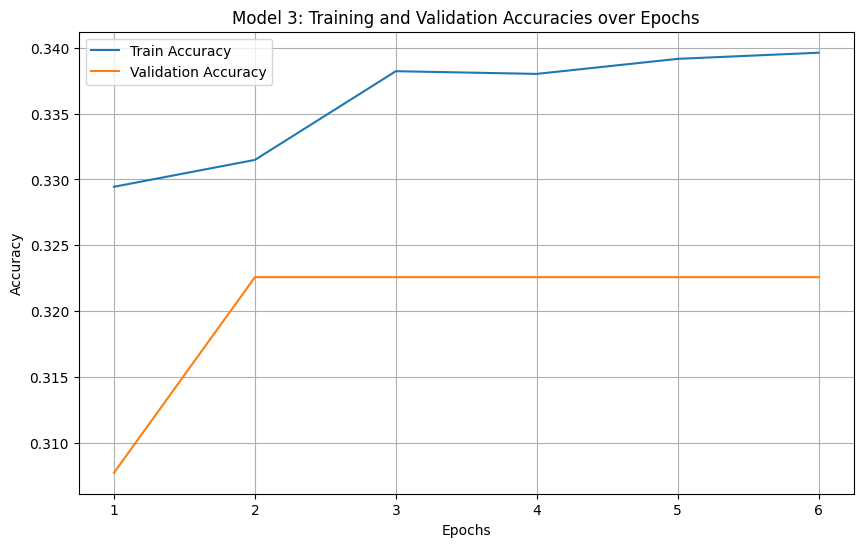

Confusion matrix plot saved as 'confusion_matrix_stackedlstm_3.png'


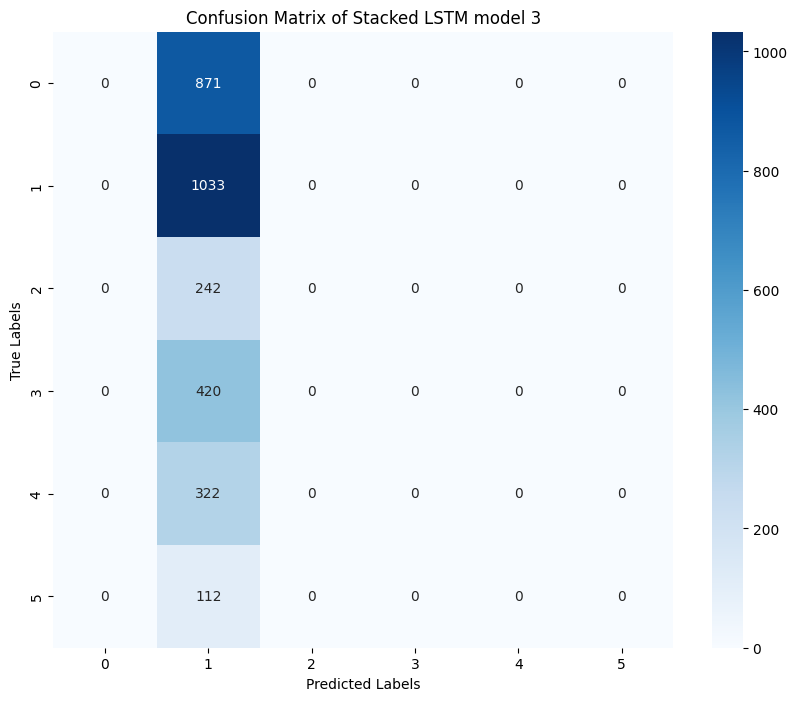

In [ ]:


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class StackedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()

        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text)

        loss = criterion(predictions, labels)
        acc = ((predictions.argmax(1) == labels).float().mean())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            outputs = model(text)

            loss = criterion(outputs, labels)
            acc = ((outputs.argmax(1) == labels).float().mean())

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            predictions.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, true_labels

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

hyperparameter_sets = [
    {"embedding_dim": 300, "hidden_dim": 256, "n_layers": 3, "dropout": 0.3},
    {"embedding_dim": 100, "hidden_dim": 128, "n_layers": 2, "dropout": 0.4},
    {"embedding_dim": 200, "hidden_dim": 256, "n_layers": 1, "dropout": 0.2},
]

for idx, params in enumerate(hyperparameter_sets):
    print(f"Training with hyperparameters set {idx+1}: {params}")

    VOCAB_SIZE = len(tokenizer.word_index) + 1
    EMBEDDING_DIM = params["embedding_dim"]
    HIDDEN_DIM = params["hidden_dim"]
    OUTPUT_DIM = 6
    N_LAYERS = params["n_layers"]
    DROPOUT = params["dropout"]

    stacked_lstm_model = StackedLSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
    stacked_lstm_model = stacked_lstm_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(stacked_lstm_model.parameters())

    N_EPOCHS = 6
    train_accuracies_stackedlstm = []
    val_accuracies_stackedlstm = []
    train_losses_stackedlstm = []
    val_losses_stackedlstm = []

    for epoch in range(N_EPOCHS):
        train_loss_stackedlstm, train_acc_stackedlstm = train(stacked_lstm_model, train_loader, optimizer, criterion)
        val_loss_stackedlstm, val_acc_stackedlstm, _, _ = evaluate(stacked_lstm_model, val_loader, criterion)

        train_accuracies_stackedlstm.append(train_acc_stackedlstm)
        val_accuracies_stackedlstm.append(val_acc_stackedlstm)
        train_losses_stackedlstm.append(train_loss_stackedlstm)
        val_losses_stackedlstm.append(val_loss_stackedlstm)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss_stackedlstm:.3f} | Train Acc: {train_acc_stackedlstm*100:.2f}%')
        print(f'\t Val. Loss: {val_loss_stackedlstm:.3f} |  Val. Acc: {val_acc_stackedlstm*100:.2f}%')

    test_loss_stackedlstm, test_acc_stackedlstm, test_predictions_stackedlstm, test_true_labels_stackedlstm = evaluate(stacked_lstm_model, test_loader, criterion)
    print(f'Test Loss: {test_loss_stackedlstm:.3f} | Test Acc: {test_acc_stackedlstm*100:.2f}%')

    #  precision, recall, and f1 score
    test_precision_stackedlstm = precision_score(test_true_labels_stackedlstm, test_predictions_stackedlstm, average='weighted')
    test_recall_stackedlstm = recall_score(test_true_labels_stackedlstm, test_predictions_stackedlstm, average='weighted')
    print(f'Test Precision: {test_precision_stackedlstm:.3f}')
    print(f'Test Recall: {test_recall_stackedlstm:.3f}')

    # Plotting the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, N_EPOCHS + 1), train_losses_stackedlstm, label='Train Loss')
    plt.plot(range(1, N_EPOCHS + 1), val_losses_stackedlstm, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Model {idx+1}: Training and Validation Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_stackedlstm_{idx+1}.png')
    print(f"Loss plot saved as 'loss_plot_stackedlstm_{idx+1}.png'")
    plt.show()

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, N_EPOCHS + 1), train_accuracies_stackedlstm, label='Train Accuracy')
    plt.plot(range(1, N_EPOCHS + 1), val_accuracies_stackedlstm, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model {idx+1}: Training and Validation Accuracies over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_plot_stackedlstm_{idx+1}.png')
    print(f"Accuracy plot saved as 'accuracy_plot_stackedlstm_{idx+1}.png'")
    plt.show()

    # Confusion matrix
    conf_mat_stackedlstm = confusion_matrix(test_true_labels_stackedlstm, test_predictions_stackedlstm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat_stackedlstm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of Stacked LSTM model {idx+1}')
    plt.savefig(f'confusion_matrix_stackedlstm_{idx+1}.png')
    print(f"Confusion matrix plot saved as 'confusion_matrix_stackedlstm_{idx+1}.png'")
    plt.show()


In [ ]:
# Save the BiLSTM model
torch.save(BiLSTM_model.state_dict(), 'bilstm_model.pth')
with open('bilstm_model.pkl', 'wb') as f:
    pickle.dump(BiLSTM_model, f)

# Load the BiLSTM model
BiLSTM_model = BiLSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
BiLSTM_model.load_state_dict(torch.load('bilstm_model.pth'))
with open('bilstm_model.pkl', 'rb') as f:
    BiLSTM_model = pickle.load(f)
BiLSTM_model.to(device)

Comparing the performance metrics for the above models

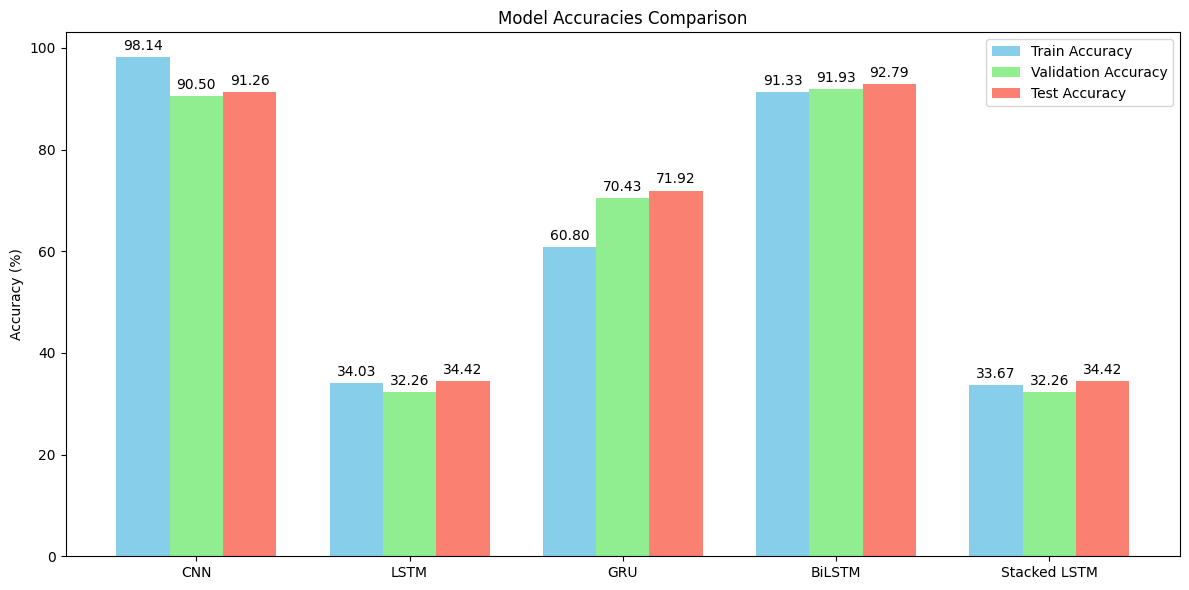

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['CNN', 'LSTM', 'GRU', 'BiLSTM', 'Stacked LSTM']
train_acc = [98.14, 34.03, 60.80, 91.33, 33.67]
val_acc = [90.50, 32.26, 70.43, 91.93, 32.26]
test_acc = [91.26, 34.42, 71.92, 92.79, 34.42]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, train_acc, width, label='Train Accuracy', color='skyblue')
rects2 = ax.bar(x, val_acc, width, label='Validation Accuracy', color='lightgreen')
rects3 = ax.bar(x + width, test_acc, width, label='Test Accuracy', color='salmon')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracies Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

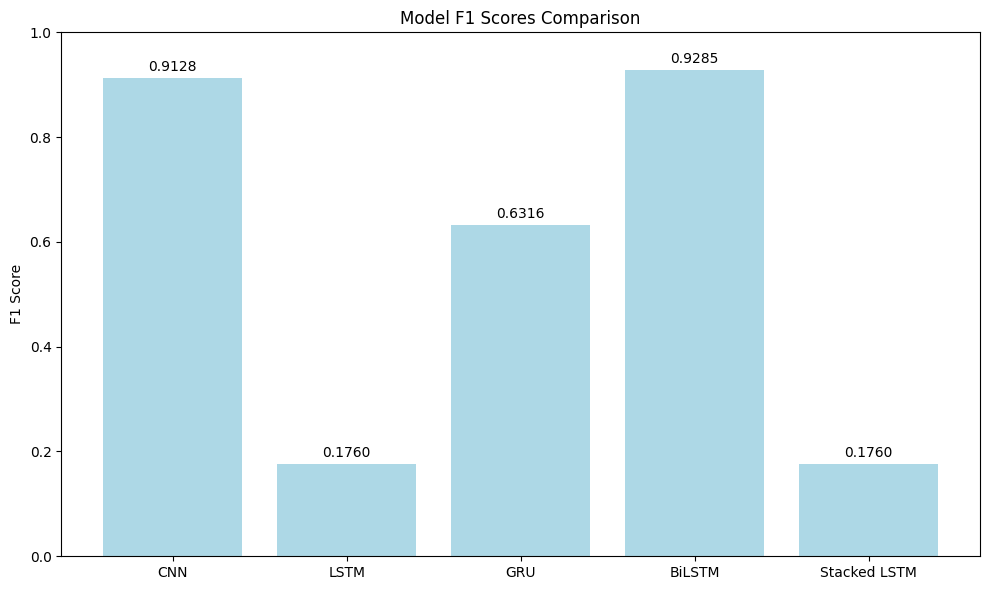

In [ ]:
# F1 Scores
f1_scores = [0.9128, 0.176, 0.6316, 0.9285, 0.176]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, f1_scores, color='lightblue')

ax.set_ylabel('F1 Score')
ax.set_title('Model F1 Scores Comparison')
ax.set_ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

Bilateral LSTM performed best overall, with high accuracy across train, validation, and test sets (92.79% test accuracy) it suggests good generalization. CNN showed strong performance, especially in training, with 91.26% test accuracy. GRU performed moderately well with 71.92% test accuracy. Both Stacked LSTM and standard LSTM significantly underperformed, with test accuracies around 34%. CNN achieved the highest training accuracy but didn't generalize as well as BiLSTM to the test set.